<a href="https://colab.research.google.com/github/leticiasdrummond/Notebooks_IT306/blob/main/1_DRUMMOND_24_10_de_2025_1_Best_Work_ModelingPVlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

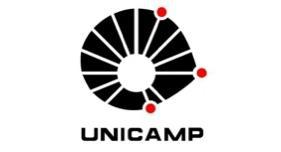

<center>
Carlos Alberto Medon Dias Ferraz

Carlos Eduardo Bento Honorio

Letícia Sampaio Drummond Valladares  
</center>
    

---

<center>

# **PROJETO I - MODELO DRUMMOND**

<center>

<center>

## **Tema: Sistemas Fotovoltaicos On-Grid e Off-Grid**

<center>

---



Professores:

   Dr. João Lucas, Dr. Gustavo Fraidenraich e Dr. Tárcio Barros
   
Monitoria:

   Me. João Frederico

<center>
03 de Novembro de 2025
<center>

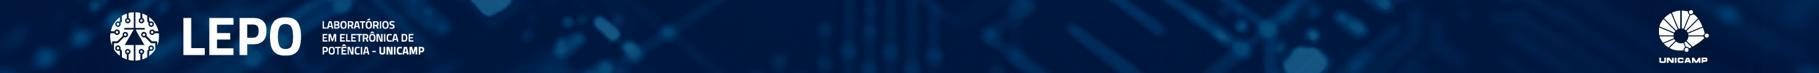

# **Introdução**

Este trabalho apresenta a modelagem de uma usina fotovoltaica (FV) utilizando a linguagem Python e a biblioteca PVlib. O objetivo principal é implementar uma cadeia completa de modelos físicos para simular a geração de energia FV, validando os resultados por meio de comparação com as simulações de referência realizadas no PVsyst.

A configuração da usina é padrão, instalação em solo, considerando um inversor com potência igual ou superior a 75 kW e um conjunto de módulos FV (monofaciais orientados para o sul), cuja potência total seja superior à do inversor. Não são consideradas as perdas por self-shading (sombreamento entre as strings).

A proposta contempla a análise de dados meteorológicos de diferentes anos, a aplicação de modelos físicos e matemáticos para estimativa da irradiância no plano dos módulos, o uso do modelo de diodo único (Single Diode Model – SDM) para cálculo da geração de energia, a consideração de perdas elétricas e térmicas e o desempenho do inversor.

Além disso, foi realizada uma simulação complementar de armazenamento em baterias LFP para avaliar a integração de sistemas híbridos. O trabalho busca não apenas reproduzir os resultados obtidos no PVsyst, mas também aprofundar a compreensão dos processos físicos envolvidos na conversão fotovoltaica.

Através do presente arquivo do notebook (.ipynb), apresentamos os códigos comentados, com descrições e títulos de seção antes de cada bloco de código.

---
---
# **Metodologia**

**Definição da Usina:**  

*   **Configuração Padrão**: Usina em solo, módulos monofaciais, orientação Sul (sem *self-shading*).
*  Inversor ≥75 kW e potência de módulo superior à do inversor.
*   Local: SOLRMAP University of Arizona (OASIS)
    
    - Latitude: 32.22969
    - Longitude: 110.95534
    - Elevação: 786 AMSL
    - Time Zone: MSTI


**Coleta de Dados Meteorológicos:** Aquisição de dados de satélite para 3 anos distintos (2019-2021), essenciais para o cálculo da irradiância.

**Modelagem em Python/PVlib:**

1.  Aplicação de modelos físicos para estimar a irradiância no plano dos módulos

2.  Cálculo da geração de energia usando o Modelo de Diodo Único (SDM)

3.  Consideração de perdas elétricas, desempenho do inversor e modelos de temperatura e céu claro (ClearSky)

4.   Análise e Comparação: Avaliação do desempenho da usina e comparação detalhada com os resultados simulados no PVsyst

5.   Análise de armazenamento em baterias LFP para explorar a integração de sistemas híbrido
`.





### **Referencias Utilizadas**
- https://assessingsolar.org/notebooks/quality_asessment.html#
- DMxxxM10RT-B60HBT/HST 490~510W

- Best Practices Handbook for the Collection and Use of Solar Resource Data for Solar Energy Applications: Fourth Edition (2024)
- Manual de Engenharia para Sistemas Fotovoltaicos (2014).

## **Instalação de bibliotecas**

In [ ]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 28.3 MB/s eta 0:00:00


In [ ]:
!pip install folium

# **Ferramentas do PVLib**


In [ ]:
# Importação das bibliotecas necessárias
import pvlib # Biblioteca para modelagem de energia solar fotovoltaica (FV)
from pvlib import location  # Módulo para definir localização geográfica
from pvlib import pvsystem
from pvlib import tools
from pvlib.pvsystem import retrieve_sam
import folium
import pandas as pd # Manipulação de dados em formato de tabela
import matplotlib.pyplot as plt # Plotagem de gráficos
from sklearn.metrics import r2_score
from scipy.constants import Boltzmann, elementary_charge
import numpy as np
from pvlib import irradiance
from pvlib.iam import physical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **1. Avaliação do Recurso Solar**
Para efeito de avaliação da qualidade do recurso solar, na regiao do Arizona (localidade da estação solarimétrica indicada para o projeto) e definição do Database metereológico a ser aplicado na modelagem fotovoltaica, foram escolhidos os dados de GHI, DHI, DNI disponíveis nas bases de dados de satélite da NSRDB e do PVGIS e da estação solarimétrica UAT - OASIS/Arizona, para os anos de 2019, 2020 e 2021.
As medições, originalmente fornecidas em bases horária ou em minuto, foram adequadas para séries diárias para possibilitar a comparação entre elas.

## **1.1 Localização de Referência da Usina Fotovoltaica**
Para este trabalho, foi considerada a seguinte localização geográfica:

| **Parâmetro**       | **Valor**               | **Descrição**                          |
|----------------------|-------------------------|----------------------------------------|
| **Nome da Estação**    | UAT	SOLRMAP University of Arizona (OASIS)	        | Estação operada pelo NREL  Measurement and Instrumentation Data Center (MIDC)            |
| **Latitude**         |32.22969            | Coordenada geográfica                  |
| **Longitude**        | -110.95534            | Coordenada geográfica                  |
| **Altitude**         | 786 metros             | Elevação em relação ao nível do mar    |
| ***Time Zone***         | MST             | *Mountain Standard Time (MST) is 7 hours behind Coordinated Universal Time (UTC). This time zone is in use during standard time in: North America. *|

FONTE:
Andreas, A.; Wilcox, S.; (2010). Observed Atmospheric and Solar Information
System (OASIS); Tucson, Arizona (2025); NREL Report No. DA-5500-56494.
http://dx.doi.org/10.5439/1052226


*   **Mapa de Referência**




In [ ]:
# @title
## Mapa de Referência
# Coordenadas geográficas (latitude, longitude, altitude) de UAT
latitude = 32.22969
longitude = -110.95534
altitude = 786  # em metros


# Criar um mapa interativo centralizado na localização
mapa = folium.Map(
    location=[latitude, longitude],
    zoom_start=12,
    tiles='OpenStreetMap'  # Tipo de mapa
)

# Adicionar um marcador no mapa
folium.Marker(
    [latitude, longitude],
    popup="Localização selecionada: SOLRMAP University of Arizona (OASIS) (UAT)",
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(mapa)

# Exibir o mapa
mapa

## **1.2 Características Relevantes da Região de Tucson**


    - Alta disponibilidade solar, com valor médio superior a 300 dias de sol/ano;
    - Região é um dos melhores locais dos EUA para geração FV;
    - Temperaturas elevadas no verão, com a atenção para a modelagem térmica na determinação das perdas;
    - Baixa nebulosidade, ideal para uso de modelos de céu claro (Haurwitz, Ineichen);
    - Clima desértico quente e seco, com ventos leves e poucas chuvas, cenário ideal para simulações de alto desempenho FV, mas requer controle de poeira.

## **1.3 Funcao da Posição Solar**

> Permite localizar a posição do sol em relação ao módulo na localidade do projeto.



In [ ]:
Latitude = 32.22969
Longitude = -110.95534
Altitude = 786
tz= 'Etc/GMT-7'

> Vale observar que usaremos a funcao do solar.position para o calculo da irradiacao incidente no módulo (Ver item 2.2)





---



## **1.4 Parâmetros Climáticos Iniciais para a Modelagem**
Para o início da modelagem foram utilizadas as seguintes variáveis metereológicas:

**Irradiação Solar**
   - GHI (Irradiância Global Horizontal) [W/m²]
   - DNI (Irradiância Direta Normal) [W/m²]
   - DHI (Irradiância Difusa Horizontal) [W/m²]

**Variáveis Ambientais**
   - Temperatura do Ar [°C]
   - Velocidade do Vento [m/s]

Para os anos 2019, 2020 e 2021, essas variáveis meteorológicas, em séries horárias (1h), foram extraidas nas bases de dados da NSRDB (NSRDB PSMv4), PVGIS (PVGIS 5.3 ERA 5) e dados medidos in loco da University of Arizona (OASIS)	Estaçao "UAT" operada pelo NREL Measurement and Instrumentation Data Center (MIDC):



## **1.5 Definicao do Database Metereológico**
A definição do Database metereológico a ser utilizado na modelagem da usina FV, foi baseada nos dados de GHI do perído de 2019 a 2021, extraídos dos dois satélites, os quais foram comparados com os dados medidos pela estação UAT, no mesmo período. A escolha do Databse metereológico, ou do satélite foi baseada em análises estatística dos parâmetros RMSE, MAE e R2.

### **1.5.1 NSRDB**

Os códigos a seguir consistem na importação dos dados horários para os anos de 2019, 2020 e 2021. Após a essa importação, os valores com discretização horária foram reajustados para escala diária.

In [ ]:
latitude = 32.22969   # Tucson, Arizona, EUA
longitude = -110.95534  # Tucson, Arizona, EUA
email = 'l298985@dac.unicamp.br'
api_key = 'UdBqiBH0jDG1heMhlE7sDhZSnJiDETFaPefAH7m4'
year_2019 = 2019
year_2020 = 2020
year_2021 = 2021

data_nsrdb_2019, meta_nsrdb = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude,longitude, api_key, email, year_2019, time_step=60, parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'), leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=60)


data_nsrdb_2020, meta_nsrdb = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude,longitude, api_key, email, year_2020, time_step=60, parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'), leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=60)


data_nsrdb_2021, meta_nsrdb = pvlib.iotools.get_nsrdb_psm4_full_disc(latitude,longitude, api_key, email, year_2021, time_step=60, parameters=('air_temperature', 'dew_point', 'dhi', 'dni', 'ghi', 'surface_albedo', 'surface_pressure', 'wind_direction', 'wind_speed'), leap_day=True, full_name='pvlib python', affiliation='pvlib python', utc=True, map_variables=True, url=None, timeout=60)

print(data_nsrdb_2019)
print(data_nsrdb_2020)
print(data_nsrdb_2021)

In [ ]:
print(data_nsrdb_2019['ghi'].resample('D').sum())
print(data_nsrdb_2020['ghi'].resample('D').sum())
print(data_nsrdb_2021['ghi'].resample('D').sum())

In [ ]:
nsrdb_data_3Y = nsrdb_data_3Y = pd.concat([data_nsrdb_2019, data_nsrdb_2020, data_nsrdb_2021], axis=0)
nsrdb_data_3Y
# Kt x Diffuse Fraction


dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)



Kt = nsrdb_data_3Y['ghi']/dni_extra

diff_fraction = nsrdb_data_3Y['dhi']/nsrdb_data_3Y['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()

### **1.5.2 PVGIS**
Os códigos a seguir foram importados do PVGIS. Vale esclarecer que "POA Global" é equivalente ao GHI quando tratamos da incidência sobre a superfície com inclinacao nula.







**2019**

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import pandas as pd

# Dados fornecidos
latitude = 32.22969
longitude = -110.95534
altitude = 786
tz = 'Etc/GMT-7'

# Obter dados horários do PVGIS usando ERA5
try:
    data = get_pvgis_hourly(
        latitude=latitude,
        longitude=longitude,
        start=2019,  # inicia em jan.
        end=2019,    # termina em dez.
        raddatabase='PVGIS-ERA5',  # Base de dados ERA5
        components=False,     # Retorna componentes de radiação
        surface_tilt=0,      # Superfície horizontal
        surface_azimuth=0,   # Orientação para sul
        outputformat='json',
        usehorizon=True,     # Considera horizonte
        userhorizon=None,    # Sem horizonte personalizado
        pvcalculation=False, # Apenas dados meteorológicos
        timeout=60
    )

    # Extrair os dados
    df = data[0]  # DataFrame com os dados horários
    metadata = data[1]  # Metadados

    print("Dados obtidos com sucesso!")
    print(f"Localização: {latitude}, {longitude}")
    print(f"Altitude: {altitude} m")
    print(f"Fuso horário: {tz}")
    print(f"Período dos dados: {df.index[0]} até {df.index[-1]}")
    print("\nPrimeiras linhas dos dados:")
    print(df.head())

    print("\nColunas disponíveis:")
    for col in df.columns:
        print(f"- {col}")

    print("\nMetadados:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Erro ao obter dados: {e}")

**2020**

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import pandas as pd

# Dados fornecidos
latitude = 32.22969
longitude = -110.95534
altitude = 786
tz = 'Etc/GMT-7'

# Obter dados horários do PVGIS usando ERA5
try:
    data_20 = get_pvgis_hourly(
        latitude=latitude,
        longitude=longitude,
        start=2020,  # Usará data padrão se None
        end=2020,    # Usará data padrão se None
        raddatabase='PVGIS-ERA5',  # Base de dados ERA5
        components=False,     # Retorna componentes de radiação
        surface_tilt=0,      # Superfície horizontal
        surface_azimuth=0,   # Orientação para sul
        outputformat='json',
        usehorizon=True,     # Considera horizonte
        userhorizon=None,    # Sem horizonte personalizado
        pvcalculation=False, # Apenas dados meteorológicos
        timeout=60
    )

    # Extrair os dados
    df_2020 = data_20[0]  # DataFrame com os dados horários
    metadata = data_20[1]  # Metadados

    # Rename the 'poa_global' column to 'poa_global_2020'
    df_2020 = df_2020.rename(columns={'poa_global': 'poa_global_2020'})

    print("Dados obtidos com sucesso!")
    print(f"Localização: {latitude}, {longitude}")
    print(f"Altitude: {altitude} m")
    print(f"Fuso horário: {tz}")
    print(f"Período dos dados: {df_2020.index[0]} até {df_2020.index[-1]}")
    print("\nPrimeiras linhas dos dados:")
    display(df_2020.head())

    print("\nColunas disponíveis:")
    for col in df_2020.columns:
        print(f"- {col}")

    print("\nMetadados:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Erro ao obter dados: {e}")

**2021**

In [ ]:
import pvlib
from pvlib.iotools import get_pvgis_hourly
import pandas as pd

# Dados fornecidos
latitude = 32.22969
longitude = -110.95534
altitude = 786
tz = 'Etc/GMT-7'

# Obter dados horários do PVGIS usando ERA5
try:
    data = get_pvgis_hourly(
        latitude=latitude,
        longitude=longitude,
        start=2021,  # Usará data padrão se None
        end=2021,    # Usará data padrão se None
        raddatabase='PVGIS-ERA5',  # Base de dados ERA5
        components=False,     # Retorna componentes de radiação
        surface_tilt=0,      # Superfície horizontal
        surface_azimuth=0,   # Orientação para sul
        outputformat='json',
        usehorizon=True,     # Considera horizonte
        userhorizon=None,    # Sem horizonte personalizado
        pvcalculation=False, # Apenas dados meteorológicos
        timeout=60
    )

    # Extrair os dados
    df_2021 = data[0]  # DataFrame com os dados horários
    metadata = data[1]  # Metadados

    # Rename the 'poa_global' column to 'poa_global_2021'
    df_2021 = df_2021.rename(columns={'poa_global': 'poa_global_2021'})

    print("Dados obtidos com sucesso!")
    print(f"Localização: {latitude}, {longitude}")
    print(f"Altitude: {altitude} m")
    print(f"Fuso horário: {tz}")
    print(f"Período dos dados: {df_2021.index[0]} até {df_2021.index[-1]}")
    print("\nPrimeiras linhas dos dados:")
    print(df_2021.head())

    print("\nColunas disponíveis:")
    for col in df_2021.columns:
        print(f"- {col}")

    print("\nMetadados:")
    for key, value in metadata.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Erro ao obter dados: {e}")

### **1.5.3 Dados de Estação UAT-OASIS**

Os dados medidos in loco são fundamentais para garantir uma escolha correta do satélite a ser utilizado na modelagem da usina FV.

**2019**

* **Medições Locais UAT**

In [ ]:
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20190101'),   # Start date jan 2019
                                                    pd.Timestamp('20191231'))   # End date dez 2019

# Rename columns to match expected names (Renomeia as colunas pela combinação esperada para melhor organização)
df_weather = df_weather.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather.head(3)

* **Mudanca da escala temporal**








In [ ]:
df_weather_ghi_horario_2019 = df_weather['ghi'].resample("H").mean()

In [ ]:
df_weather_ghi_horario_2019.resample("D").sum().plot(label ='referencia', figsize=(15,5))
data_nsrdb_2019['ghi'].resample('D').sum().plot(label ='nsrdb', figsize=(15,5))
df['poa_global'].resample('D').sum().plot(label ='pvgis', figsize=(15,5))
plt.legend()

**2020**

* **Medições Locais UAT**

In [ ]:
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather_2020 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20200101'),   # Start date jan 2020
                                                    pd.Timestamp('20201231'))   # End date dez 2020

# Rename columns to match expected names
df_weather_2020 = df_weather_2020.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather_2020.head(3)

* **Mudanca da escala temporal**

In [ ]:
df_weather_ghi_horario_2020 = df_weather_2020['ghi'].resample("H").mean()

In [ ]:
df_weather_ghi_horario_2020.resample("D").sum().plot(label ='referencia_2020', figsize=(15,5))
data_nsrdb_2020['ghi'].resample('D').sum().plot(label ='nsrdb_2020', figsize=(15,5))
df_2020['poa_global_2020'].resample('D').sum().plot(label ='pvgis_2020', figsize=(15,5))
plt.legend()

**2021**

 * **MEDICOES LOCAIS UAT**

In [ ]:
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather_2021.head(3)

* **Mudanca da escala temporal**

In [ ]:
df_weather_ghi_horario_2021 = df_weather_2021['ghi'].resample("H").mean()

In [ ]:
df_weather_ghi_horario_2021.resample("D").sum().plot(label ='referencia_2021', figsize=(15,5))
data_nsrdb_2021['ghi'].resample('D').sum().plot(label ='nsrdb_2021', figsize=(15,5))
df_2021['poa_global_2021'].resample('D').sum().plot(label ='pvgis_2021', figsize=(15,5))
plt.legend()

### **1.5.4 Comparação das Métricas de Avaliação**
Pra escolha do Database metereológico foram aplicadas as métricas de avaliação RMSE, MAE e R2 para o GHI.


**Ano 2019**

In [ ]:
daily_reference_2019 = df_weather_ghi_horario_2019.resample("D").sum()
daily_nsrdb_2019 = data_nsrdb_2019['ghi'].resample('D').sum()
daily_pvgis_2019 = df['poa_global'].resample('D').sum()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas de avaliação
rmse = np.sqrt(mean_squared_error(daily_reference_2019, daily_nsrdb_2019))
mae = mean_absolute_error(daily_reference_2019, daily_nsrdb_2019)
r2 = r2_score(daily_reference_2019, daily_nsrdb_2019)
bias = np.mean(daily_nsrdb_2019 - daily_reference_2019)

print("\n--- Métricas de Avaliação NSRDB 2019---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

rmse = np.sqrt(mean_squared_error(daily_reference_2019, daily_pvgis_2019))
mae = mean_absolute_error(daily_reference_2019, daily_pvgis_2019)
r2 = r2_score(daily_reference_2019, daily_pvgis_2019)
bias = np.mean(daily_nsrdb_2019 - daily_pvgis_2019)

print("\n--- Métricas de Avaliação PVGIS 2019 ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

* Constata-se que os dados do NSRDB, para o ano de 2019, possui melhor aderência aos dados medidos pela estação UAT, em comparação com os dados do PVGIS.

**Ano 2020**


In [ ]:
daily_reference_2020 = df_weather_ghi_horario_2020.resample("D").sum()
daily_nsrdb_2020 = data_nsrdb_2020['ghi'].resample('D').sum()
daily_pvgis_2020 = df_2020['poa_global_2020'].resample('D').sum()

In [ ]:
#dados do ano de 2020
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas de avaliação
rmse = np.sqrt(mean_squared_error(daily_reference_2020, daily_nsrdb_2020))
mae = mean_absolute_error(daily_reference_2020, daily_nsrdb_2020)
r2 = r2_score(daily_reference_2020, daily_nsrdb_2020)
bias = np.mean(daily_nsrdb_2020 - daily_reference_2020)

print("\n--- Métricas de Avaliação NSRDB 2020---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

rmse = np.sqrt(mean_squared_error(daily_reference_2020, daily_pvgis_2020))
mae = mean_absolute_error(daily_reference_2020, daily_pvgis_2020)
r2 = r2_score(daily_reference_2020, daily_pvgis_2020)
bias = np.mean(daily_nsrdb_2020 - daily_pvgis_2020)

print("\n--- Métricas de Avaliação PVGIS 2020 ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

Constata-se que os dados do NSRDB, para o ano de 2020, continua sendo a base indicada.

**2021**


In [ ]:
daily_reference_2021 = df_weather_ghi_horario_2021.resample("D").sum()
daily_nsrdb_2021 = data_nsrdb_2021['ghi'].resample('D').sum()
daily_pvgis_2021 = df_2021['poa_global_2021'].resample('D').sum()

In [ ]:
#dados do ano de 2021
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Métricas de avaliação
rmse = np.sqrt(mean_squared_error(daily_reference_2021, daily_nsrdb_2021))
mae = mean_absolute_error(daily_reference_2021, daily_nsrdb_2021)
r2 = r2_score(daily_reference_2021, daily_nsrdb_2021)
bias = np.mean(daily_nsrdb_2021 - daily_reference_2021)

print("\n--- Métricas de Avaliação NSRDB 2021---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

rmse = np.sqrt(mean_squared_error(daily_reference_2021, daily_pvgis_2021))
mae = mean_absolute_error(daily_reference_2021, daily_pvgis_2021)
r2 = r2_score(daily_reference_2021, daily_pvgis_2021)
bias = np.mean(daily_nsrdb_2021 - daily_pvgis_2021)

print("\n--- Métricas de Avaliação PVGIS 2021 ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

* Novamente, constata-se que os dados do NSRDB, para o ano de 2021, continua sendo a base indicada em comparação com a base de dados do PVGIS.


---



In [ ]:
# Kt x Diffuse Fraction


dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)



Kt = nsrdb_data_3Y['ghi']/dni_extra

diff_fraction = nsrdb_data_3Y['dhi']/nsrdb_data_3Y['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()


### **1.5.5 Conclusão da Escolha da Base de Dados de Satélite (GHI)**

Em função das análises das métricas de avaliação realizadas nos itens anteriores, a base de dados do NSRDB será adotada para a geração dos dados de GHI, os quais serão utilizados para obter os valores de do DNI e DHI, por meio de diversos métodos de decomposicao.

## **1.6 Métodos de Decomposição para Determinacao do DNI e DHI**


A partir dos valores gerados de GHI da base de dados do NSRDB, os valores de DNI e DHI foram determinados pelos métodos de decomposicao, a saber:

**1.   ERBS**
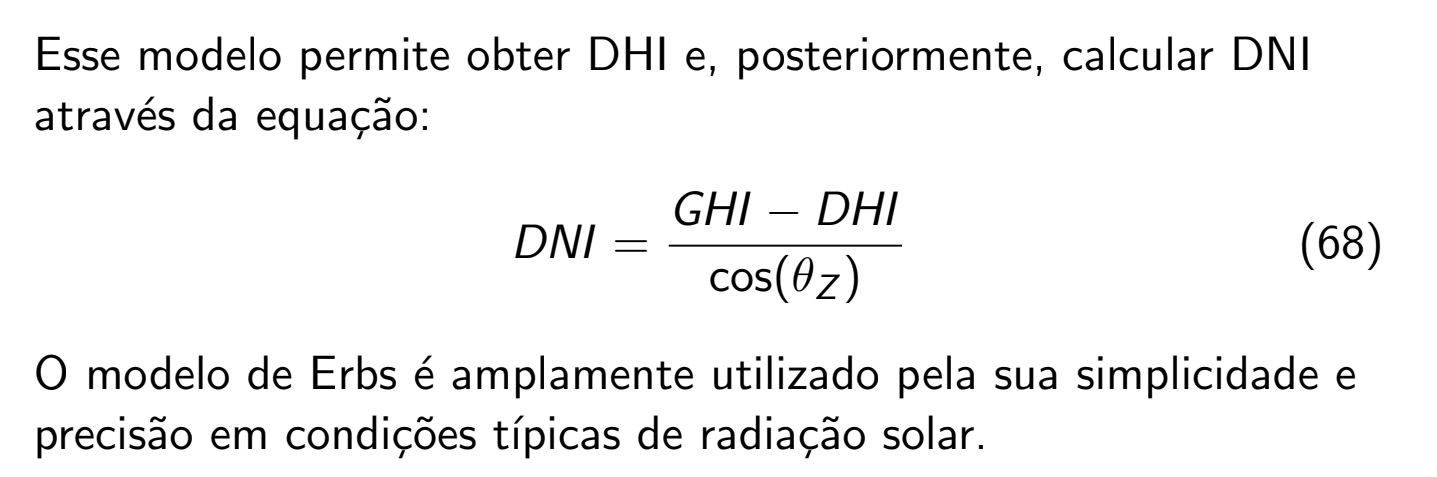
**2.   DIRINT**
* O modelo DIRINT  ́e uma modificacao dinamica do modelo DISC.
* Objetivo: Estimar a Irradiancia Normal Direta (DNI) a partir da Irradiancia Global Horizontal (GHI).
* Desenvolvido por Perez et al. (1992).
* Usa séries temporais de GHI e pode incluir a temperatura do ponto de orvalho (Tdew).


**3.   DISC**

O modelo DISC (*Direct Insolation Simulation Code*) em pvlib é uma metodologia que estima a Irradiância Normal Direta (DNI) a partir da Irradiância Horizontal Global (GHI). Ele foi desenvolvido no National Renewable Energy Laboratory (NREL) em 1987 e utiliza relações empíricas entre os índices de nebulosidade global e direta para decompor a irradiância solar.

[1] Maxwell, E. L., "A Quasi-Physical Model for Converting Hourly
        Global Horizontal to Direct Normal Insolation", Technical
        Report No. SERI/TR-215-3087, Golden, CO: Solar Energy Research
        Institute, 1987.

[2] Maxwell, E. "DISC Model", Excel Worksheet.
        https://www.nrel.gov/grid/solar-resource/disc.html

**4.   BOLAND**

>   Como referência, foram utilizados os programas desenvolvidos no Notebook 3 e auxílio complementar de IA



### **1.6.1 Decomposição referente ao ano de 2019**










In [ ]:
from pvlib import irradiance
import pvlib # Import pvlib

# Use os dados de 2019 do NSRDB para o cálculo da posição solar
solpos = pvlib.solarposition.get_solarposition(time=data_nsrdb_2019.index,
                                                latitude=latitude,
                                                longitude=longitude)

# O modelo Erbs utiliza o GHI medido e o ângulo zenital solar.
# Usando GHI dos dados de 2019 do NSRDB
out_erbs = irradiance.erbs(data_nsrdb_2019['ghi'], solpos['zenith'], data_nsrdb_2019.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

In [ ]:
out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
df_weather['dhi'].plot(label = 'Measured Data')
plt.legend()
plt.show()

In [ ]:
out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
df_weather['dni'].plot(label = 'Measured Data')
plt.legend()
plt.show()

In [ ]:
#Modelagem de Decomposição com outros modelos de decomposição
#DISC - O modelo DISC utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2019 do NSRDB
out_disc = irradiance.disc(
    data_nsrdb_2019['ghi'], solpos.zenith, data_nsrdb_2019.index, data_nsrdb_2019['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2019['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

#BOLAND - O modelo Boland utiliza o GHI medido, o ângulo zenital solar e o índice temporal.
# Usando dados de 2019 do NSRDB
out_boland = irradiance.boland(data_nsrdb_2019['ghi'], solpos.zenith, data_nsrdb_2019.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

#DIRINT - O modelo Dirint utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2019 do NSRDB
dni_dirint = irradiance.dirint(
    data_nsrdb_2019['ghi'], solpos.zenith, data_nsrdb_2019.index, data_nsrdb_2019['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2019['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=data_nsrdb_2019.index)

In [ ]:
#Comparando DHI
out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
out_dirint['dhi_dirint'].plot(label = 'DHI Dirint')
out_disc['dhi_disc'].plot(label = 'DHI Disc')
out_boland['dhi_boland'].plot(label = 'DHI Boland')
df_weather['dhi'].plot(label = 'Measured Data')
print(out_erbs['dhi_erbs'].sum())
print(out_dirint['dhi_dirint'].sum())
print(out_disc['dhi_disc'].sum())
print(out_boland['dhi_boland'].sum())
print(df_weather['dhi'].sum())
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DHI
models_dhi = {
    'DHI Erbs': out_erbs['dhi_erbs'],
    'DHI Dirint': out_dirint['dhi_dirint'],
    'DHI Disc': out_disc['dhi_disc'],
    'DHI Boland': out_boland['dhi_boland']
}

# Dados medidos para DHI
measured_dhi = df_weather['dhi']

# 1. Plot comparativo temporal DHI
plt.figure(figsize=(20, 8))
for name, model in models_dhi.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dhi.plot(label='DHI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DHI', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DHI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DHI
metrics_dhi = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dhi.items():
    valid_idx = measured_dhi.notna() & model.notna()
    y_true = measured_dhi[valid_idx]
    y_pred = model[valid_idx]

    # Check if there are enough samples for metrics calculation
    if len(y_true) > 1:
        metrics_dhi.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
        metrics_dhi.loc[name] = {col: np.nan for col in metrics_dhi.columns}


# 3. Gráficos de dispersão com ajuste linear para DHI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dhi.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dhi.notna() & model.notna()
    x = measured_dhi[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')

        plt.xlabel('DHI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido\nR² = {metrics_dhi.loc[name, "R²"]:.2f}', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')

plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DHI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dhi.items(), 1):
    error = model - measured_dhi

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name}', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DHI
plt.figure(figsize=(12, 6))
all_errors_dhi = []
labels_dhi = []
for name, model in models_dhi.items():
    error = model - measured_dhi
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dhi.append(clean_error)
        labels_dhi.append(name)

if len(all_errors_dhi) > 0:
    plt.boxplot(all_errors_dhi, tick_labels=labels_dhi, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DHI', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DHI.")

# Calculate total energy for DHI
energy_dhi = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dhi.items():
    energy_dhi.loc[name] = model.sum()
energy_dhi.loc['Dados Medidos'] = measured_dhi.sum()

In [ ]:
#Comparando DNI
out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
out_dirint['dni_dirint'].plot(label = 'DNI Dirint')
out_disc['dni_disc'].plot(label = 'DNI Disc')
out_boland['dni_boland'].plot(label = 'DNI Boland')
df_weather['dni'].plot(label = 'Measured Data')
print(out_erbs['dni_erbs'].sum())
print(out_dirint['dni_dirint'].sum())
print(out_disc['dni_disc'].sum())
print(out_boland['dni_boland'].sum())
print(df_weather['dni'].sum())
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DNI
models_dni = {
    'DNI Erbs': out_erbs['dni_erbs'],
    'DNI Dirint': out_dirint['dni_dirint'],
    'DNI Disc': out_disc['dni_disc'],
    'DNI Boland': out_boland['dni_boland']
}

# Dados medidos para DNI
measured_dni = df_weather['dni']

# 1. Plot comparativo temporal DNI
plt.figure(figsize=(20, 8))
for name, model in models_dni.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dni.plot(label='DNI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DNI', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DNI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DNI
metrics_dni = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dni.items():
    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model)
    y_true = measured_dni[valid_idx]
    y_pred = model[valid_idx]

    if len(y_true) > 1:
        metrics_dni.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
         metrics_dni.loc[name] = {col: np.nan for col in metrics_dni.columns}


# 3. Gráficos de dispersão com ajuste linear para DNI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dni.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model) & ~np.isinf(measured_dni)
    x = measured_dni[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
            r2 = r2_score(x, y)
        except:
            r2 = np.nan

        plt.xlabel('DNI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido\nR² = {r2:.2f}' if not np.isnan(r2) else f'{name} vs Medido', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')


plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DNI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dni.items(), 1):
    error = model - measured_dni

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name}', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DNI
plt.figure(figsize=(12, 6))
all_errors_dni = []
labels_dni = []
for name, model in models_dni.items():
    error = model - measured_dni
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dni.append(clean_error)
        labels_dni.append(name)

if len(all_errors_dni) > 0:
    plt.boxplot(all_errors_dni, tick_labels=labels_dni, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DNI', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DNI.")

# Calculate total energy for DNI
energy_dni = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dni.items():
    energy_dni.loc[name] = model.sum()
energy_dni.loc['Dados Medidos'] = measured_dni.sum()

# Combine metrics into a single table
metrics_combined = pd.concat([metrics_dhi, metrics_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])
energy_combined = pd.concat([energy_dhi, energy_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])

# Add measured data row to the combined metrics table
metrics_combined.loc[('DHI', 'Dados Medidos'), :] = np.nan
metrics_combined.loc[('DNI', 'Dados Medidos'), :] = np.nan

# Combine metrics and energy
combined_results = pd.concat([metrics_combined, energy_combined], axis=1)

# Display the combined table
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho Combinadas (DHI e DNI) ===")
print(combined_results)

**Conclusões para ano de 2019:**

Após as simulações, foi possível verificar que, em relação ao RMSE:

*  DHI Boland apresentou melhor resultado, pois os seus dados estao mais aderente aos dados medidos na estacao da UAT;
*  DNI Erbs apresentou o melhor resultado, seguido por Boland com pequena diferenca.

### **1.6.2 Decomposição referente ao ano de 2020**



>

In [ ]:
from pvlib import irradiance
import pvlib # Import pvlib

# Use os dados de 2020 do NSRDB para o cálculo da posição solar
solpos = pvlib.solarposition.get_solarposition(time=data_nsrdb_2020.index,
                                                latitude=latitude,
                                                longitude=longitude)

# O modelo Erbs utiliza o GHI medido e o ângulo zenital solar.
# Usando GHI dos dados de 2020 do NSRDB
out_erbs = irradiance.erbs(data_nsrdb_2020['ghi'], solpos['zenith'], data_nsrdb_2020.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
df_weather_2020['dhi'].plot(label = 'Measured Data')
plt.legend()
plt.show()

out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
df_weather_2020['dni'].plot(label = 'Measured Data')
plt.legend()
plt.show()

#Modelagem de Decomposição com outros modelos de decomposição
#DISC - O modelo DISC utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2020 do NSRDB
out_disc = irradiance.disc(
    data_nsrdb_2020['ghi'], solpos.zenith, data_nsrdb_2020.index, data_nsrdb_2020['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2020['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

#BOLAND - O modelo Boland utiliza o GHI medido, o ângulo zenital solar e o índice temporal.
# Usando dados de 2020 do NSRDB
out_boland = irradiance.boland(data_nsrdb_2020['ghi'], solpos.zenith, data_nsrdb_2020.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

#DIRINT - O modelo Dirint utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2020 do NSRDB
dni_dirint = irradiance.dirint(
    data_nsrdb_2020['ghi'], solpos.zenith, data_nsrdb_2020.index, data_nsrdb_2020['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2020['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=data_nsrdb_2020.index)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DNI
models_dni = {
    'DNI Erbs': out_erbs['dni_erbs'],
    'DNI Dirint': out_dirint['dni_dirint'],
    'DNI Disc': out_disc['dni_disc'],
    'DNI Boland': out_boland['dni_boland']
}

# Dados medidos para DNI
measured_dni = df_weather_2020['dni']

# 1. Plot comparativo temporal DNI
plt.figure(figsize=(20, 8))
for name, model in models_dni.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dni.plot(label='DNI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DNI', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DNI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DNI
metrics_dni = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dni.items():
    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model)
    y_true = measured_dni[valid_idx]
    y_pred = model[valid_idx]

    if len(y_true) > 1:
        metrics_dni.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
         metrics_dni.loc[name] = {col: np.nan for col in metrics_dni.columns}


# 3. Gráficos de dispersão com ajuste linear para DNI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dni.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model) & ~np.isinf(measured_dni)
    x = measured_dni[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
            r2 = r2_score(x, y)
        except:
            r2 = np.nan

        plt.xlabel('DNI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido\nR² = {r2:.2f}' if not np.isnan(r2) else f'{name} vs Medido', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')


plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DNI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dni.items(), 1):
    error = model - measured_dni

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name}', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DNI
plt.figure(figsize=(12, 6))
all_errors_dni = []
labels_dni = []
for name, model in models_dni.items():
    error = model - measured_dni
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dni.append(clean_error)
        labels_dni.append(name)

if len(all_errors_dni) > 0:
    plt.boxplot(all_errors_dni, tick_labels=labels_dni, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DNI', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DNI.")

# Calculate total energy for DNI
energy_dni = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dni.items():
    energy_dni.loc[name] = model.sum()
energy_dni.loc['Dados Medidos'] = measured_dni.sum()

# Combine metrics into a single table
metrics_combined = pd.concat([metrics_dhi, metrics_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])
energy_combined = pd.concat([energy_dhi, energy_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])

# Add measured data row to the combined metrics table
metrics_combined.loc[('DHI', 'Dados Medidos'), :] = np.nan
metrics_combined.loc[('DNI', 'Dados Medidos'), :] = np.nan

# Combine metrics and energy
combined_results = pd.concat([metrics_combined, energy_combined], axis=1)

# Display the combined table
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho Combinadas (DHI e DNI) ===")
print(combined_results)

**Conclusões para ano de 2020:**
Após as simulações, foi possível verificar que, em relacao ao RMSE:

*  DHI Boland teve melhor resultado, sendo mais aderente aos dados medidos;
*  DNI Disc teve o melhor resultado, seguido por Erbs com pequena diferença.




---



---



### **1.6.3 Decomposição referente ao ano de 2021**

In [ ]:
from pvlib import irradiance
import pvlib # Import pvlib

# Use os dados de 2021 do NSRDB para o cálculo da posição solar
solpos = pvlib.solarposition.get_solarposition(time=data_nsrdb_2021.index,
                                                latitude=latitude,
                                                longitude=longitude)

# O modelo Erbs utiliza o GHI medido e o ângulo zenital solar.
# Usando GHI dos dados de 2021 do NSRDB
out_erbs = irradiance.erbs(data_nsrdb_2021['ghi'], solpos['zenith'], data_nsrdb_2021.index)
out_erbs = out_erbs.rename(columns={'dni': 'dni_erbs', 'dhi': 'dhi_erbs'})

out_erbs['dhi_erbs'].plot(label = 'DHI Erbs', figsize=(20,6))
df_weather_2021['dhi'].plot(label = 'Measured Data')
plt.legend()
plt.show()

out_erbs['dni_erbs'].plot(label = 'DNI Erbs', figsize=(20,6))
df_weather_2021['dni'].plot(label = 'Measured Data')
plt.legend()
plt.show()

#Modelagem de Decomposição com outros modelos de decomposição
#DISC - O modelo DISC utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2021 do NSRDB
out_disc = irradiance.disc(
    data_nsrdb_2021['ghi'], solpos.zenith, data_nsrdb_2021.index, data_nsrdb_2021['pressure']*100)
# use "complete sum" AKA "closure" equations: DHI = GHI - DNI * cos(zenith)
df_disc = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2021['ghi'], dni=out_disc.dni,
    dhi=None)
out_disc = out_disc.rename(columns={'dni': 'dni_disc'})
out_disc['dhi_disc'] = df_disc.dhi

#BOLAND - O modelo Boland utiliza o GHI medido, o ângulo zenital solar e o índice temporal.
# Usando dados de 2021 do NSRDB
out_boland = irradiance.boland(data_nsrdb_2021['ghi'], solpos.zenith, data_nsrdb_2021.index)
out_boland = out_boland.rename(
    columns={'dni': 'dni_boland', 'dhi': 'dhi_boland'})

#DIRINT - O modelo Dirint utiliza o GHI medido, o ângulo zenital solar, o índice temporal e a pressão do ar.
# Usando dados de 2021 do NSRDB
dni_dirint = irradiance.dirint(
    data_nsrdb_2021['ghi'], solpos.zenith, data_nsrdb_2021.index, data_nsrdb_2021['pressure']*100,
    temp_dew=None)
# use "complete sum" AKA "closure" equation: DHI = GHI - DNI * cos(zenith)
df_dirint = irradiance.complete_irradiance(
    solar_zenith=solpos.apparent_zenith, ghi=data_nsrdb_2021['ghi'], dni=dni_dirint,
    dhi=None)
out_dirint = pd.DataFrame(
    {'dni_dirint': dni_dirint, 'dhi_dirint': df_dirint.dhi},
    index=data_nsrdb_2021.index)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde

# Dados dos modelos para DNI
models_dni = {
    'DNI Erbs': out_erbs['dni_erbs'],
    'DNI Dirint': out_dirint['dni_dirint'],
    'DNI Disc': out_disc['dni_disc'],
    'DNI Boland': out_boland['dni_boland']
}

# Dados medidos para DNI
measured_dni = df_weather_2021['dni']

# 1. Plot comparativo temporal DNI
plt.figure(figsize=(20, 8))
for name, model in models_dni.items():
    model.plot(label=name, alpha=0.7, linewidth=1.5)
measured_dni.plot(label='DNI Medido', color='black', linewidth=2.5, style='--')
plt.title('Comparação Temporal de Modelos de DNI - 2021', fontsize=16, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('DNI (W/m²)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cálculo das métricas para DNI
metrics_dni = pd.DataFrame(columns=['RMSE (W/m²)', 'MAE (W/m²)', 'R²', 'Bias (W/m²)'])

for name, model in models_dni.items():
    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model)
    y_true = measured_dni[valid_idx]
    y_pred = model[valid_idx]

    if len(y_true) > 1:
        metrics_dni.loc[name] = {
            'RMSE (W/m²)': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE (W/m²)': mean_absolute_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred),
            'Bias (W/m²)': np.mean(y_pred - y_true)
        }
    else:
         metrics_dni.loc[name] = {col: np.nan for col in metrics_dni.columns}


# 3. Gráficos de dispersão com ajuste linear para DNI
plt.figure(figsize=(15, 12))
for i, (name, model) in enumerate(models_dni.items(), 1):
    plt.subplot(2, 2, i)

    valid_idx = measured_dni.notna() & model.notna() & ~np.isinf(model) & ~np.isinf(measured_dni)
    x = measured_dni[valid_idx]
    y = model[valid_idx]

    if len(x) > 1:
        plt.scatter(x, y, alpha=0.3, color=plt.cm.tab10(i-1))
        plt.plot([0, max(x)], [0, max(x)], 'r--', label='Linha 1:1')

        try:
            coef = np.polyfit(x, y, 1)
            poly1d_fn = np.poly1d(coef)
            plt.plot(x, poly1d_fn(x), 'k-', label=f'Ajuste: y={coef[0]:.2f}x+{coef[1]:.2f}')
            r2 = r2_score(x, y)
        except:
            r2 = np.nan

        plt.xlabel('DNI Medido (W/m²)', fontsize=10)
        plt.ylabel(f'{name} (W/m²)', fontsize=10)
        plt.title(f'{name} vs Medido - 2021\nR² = {r2:.2f}' if not np.isnan(r2) else f'{name} vs Medido - 2021', fontsize=12)
        plt.legend(fontsize=9)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'{name} (Dados insuficientes)')


plt.tight_layout()
plt.show()

# 4. Análise de distribuição de erros para DNI
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(models_dni.items(), 1):
    error = model - measured_dni

    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) == 0:
        plt.subplot(2, 2, i)
        plt.text(0.5, 0.5, 'Dados insuficientes', ha='center', va='center')
        plt.title(f'Distribuição de Erros - {name}')
        continue

    plt.subplot(2, 2, i)
    n, bins, patches = plt.hist(clean_error, bins=50, density=True,
                              alpha=0.7, color=plt.cm.tab10(i-1))
    plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
    current_bias = np.mean(clean_error)
    plt.axvline(x=current_bias, color='k',
               linestyle='-', linewidth=1.5, label=f'Bias: {current_bias:.2f}')

    try:
        kde = gaussian_kde(clean_error)
        x_vals = np.linspace(min(clean_error), max(clean_error), 100)
        plt.plot(x_vals, kde(x_vals), 'b-', linewidth=1.5)
    except Exception as e:
        print(f"\nAviso: Não foi possível calcular KDE para {name}. Erro: {str(e)}")

    plt.title(f'Distribuição de Erros - {name} - 2021', fontsize=12)
    plt.xlabel('Erro (W/m²)', fontsize=10)
    plt.ylabel('Densidade', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Boxplot comparativo de erros para DNI
plt.figure(figsize=(12, 6))
all_errors_dni = []
labels_dni = []
for name, model in models_dni.items():
    error = model - measured_dni
    clean_error = error.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_error) > 0:
        all_errors_dni.append(clean_error)
        labels_dni.append(name)

if len(all_errors_dni) > 0:
    plt.boxplot(all_errors_dni, tick_labels=labels_dni, patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='darkblue'),
               medianprops=dict(color='red'))
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Distribuição Comparativa de Erros - DNI - 2021', fontsize=14)
    plt.ylabel('Erro (W/m²)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nAviso: Não há dados válidos para gerar o boxplot comparativo de DNI.")

# Calculate total energy for DNI
energy_dni = pd.DataFrame(columns=['Energia Total (Wh/m²)'])
for name, model in models_dni.items():
    energy_dni.loc[name] = model.sum()
energy_dni.loc['Dados Medidos'] = measured_dni.sum()

# Combine metrics into a single table
metrics_combined = pd.concat([metrics_dhi, metrics_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])
energy_combined = pd.concat([energy_dhi, energy_dni], keys=['DHI', 'DNI'], names=['Irradiance Component', 'Model'])

# Add measured data row to the combined metrics table
metrics_combined.loc[('DHI', 'Dados Medidos'), :] = np.nan
metrics_combined.loc[('DNI', 'Dados Medidos'), :] = np.nan

# Combine metrics and energy
combined_results = pd.concat([metrics_combined, energy_combined], axis=1)

# Display the combined table
pd.set_option('display.float_format', '{:.2f}'.format)
print("\n=== Métricas de Desempenho Combinadas (DHI e DNI) - 2021 ===")
print(combined_results)

**Conclusões para ano de 2021:**

Após as simulações, foi possível verificar que, em relacao ao RMSE:

*  DHI Boland teve melhor resultado, sendo mais aderente aos dados medidos;
*  DNI Erbs teve o melhor resultado.

### **1.6.4 Análise dos Resultados de Decomposicao para 2019 a 2021**

Para modelagem foram escolhidos os dados relativos ao ano de  2021 que apresentaram melhores resultados, conforme a métrica RMSE, em comparação com os dados de 2019 e 2020

O modelo Boland apresentou melhor performance para DHI, enquanto para DNI os modelos Erbs e Disc se alternam como melhores dependendo do critério de avaliação

Definição dos modelos a serem utilizados na modelagem:

  * **DHI**
    Modelo Boland

 *  **DNI**
    Modelo Erbs

 * **GHI**
    Valores medidos para o ano de 2021.

\

---



---



---



## **1.7 Qualidade do Recurso Solar**

Para compreendermos a qualidade, composição e comportamento do recurso solar no local da usina FV localizada emk OASIS- Arizona, foram utilizadas as seguintes ferramentas gráficas de análise solarimétrica:

### **1.7.1 Fração Difusa (DHI/GHI) vs Índice de claridade (Kt)**
Mostra a relação entre a fração difusa da radiação e o nível de transparência da atmosfera, ou seja, classifica o tipo de céu (limpo, misto, nublado), bem como validar a decomposição do modelo

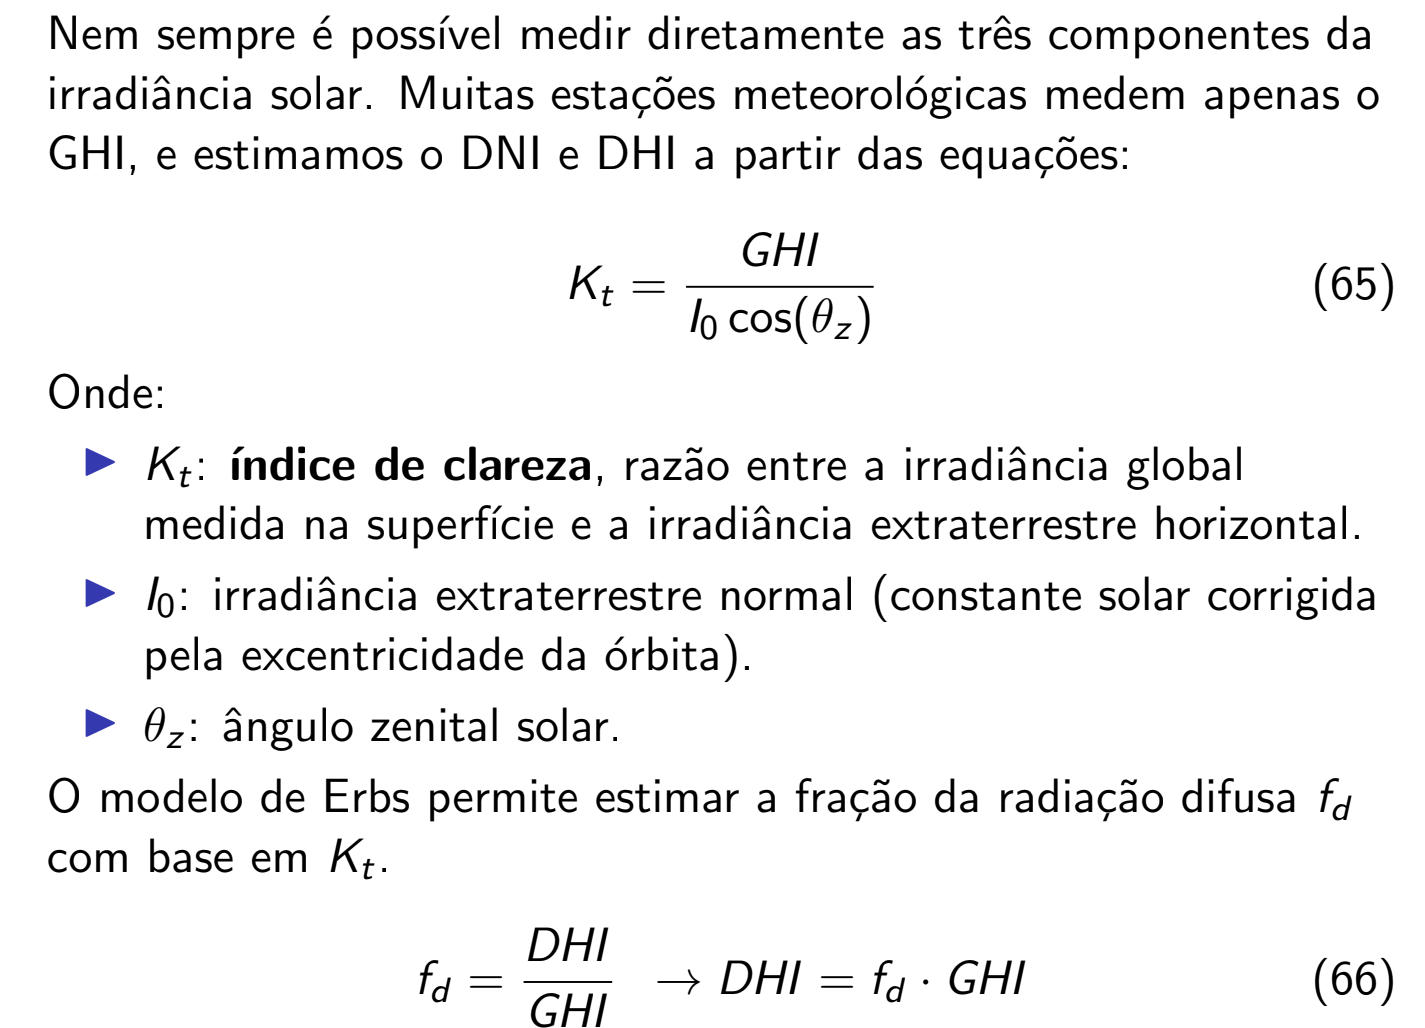


### **1.7.1.1 Gráfico: Fração Difusa (DHI / GHI) vs Kt (GHI / (H0*cos (θz)))**

###Relação entre Fração Difusa e Índice de Claridade Atmosférica  (Kt)**

**Fração Difusa = DHI / GHI**  
**Índice de Claridade Atmosférica  (Kt) = GHI / (H₀ × cos(θz))**

Onde:
- **H₀**: Irradiância extraterrestre no plano horizontal
- **θz**: Ângulo zenital solar

**Análise:**
- **Kt alto (> 0,6)**: Condições de céu claro → menor fração difusa
- **Kt baixo (< 0,3)**: Céu encoberto → maior fração difusa
- **Relação inversa** esperada entre Kt e fração difusa

> *“O índice de claridade atmosférica (Kt) é um indicador direto da predominância de componentes direta ou difusa.”* (LUNA, 2022, p. 17)


In [ ]:
# Kt x Diffuse Fraction
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
Kt = df_weather['ghi']/dni_extra
diff_fraction = df_weather['dhi']/df_weather['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()

### **1.7.2 Componentes do Recurso Solar na Horizontal vs Ângulo zenital**
Informa como a irradiância global na horizontal (GHI) varia com o ângulo zenital do Sol, ou seja, com a altura solar no céu. A irradiância é máxima quando o Sol está próximo do zênite (meio-dia) e diminui à medida que o Sol se aproxima do horizonte (ângulo zenital aumenta).

Tem a finalidade de visualizar o perfil diário do recurso solar, avaliar perdas geométricas em superfícies horizontais e determinar horários mais produtivos para sistemas FV.


In [ ]:
# @title


### **1.7.3 Inspeção Visual de Duas Dimensões (GHI, DNI e DHI)**
É um gráfico de dispersão ou mapa 2D que representa simultaneamente as componentes do recurso solar, GHI, DNI e DHI

Mostra a consistência ente os componentes e avalia a consistência e qualidade dos dados

### **1.6.5 Dados Solarimétricos Ano 2021**

Para modelagem foi escolhido os dados relativos a 2021 que apresentaram melhores resultados, conforme a métrica RMSE, em comparação com os dados de 2019 e 2020



* Componentes do recurso solar na horizontal vs ângulo zenital
* Inspeção visual de duas dimensões(GHI, DNI e DHI)



---

**Selecao de 1 ano para Análises**

Para modelagens que permitem uso de apenas um dos anos, os dados relativos a 2021 foram selecionados em razão do melhor resultado comparado ao RMSE para 2019 e 2020.

O Código seguinte apenas apresenta os dados solarimétricos, Temp. Amb. e Velocidade do vento para o ano de 2021:


In [ ]:
# @title
# Calculate annual and monthly averages for the specified parameters for 2021

# GHI from UAT station data 2021
ghi_uat_2021_annual = df_weather_2021['ghi'].sum()
ghi_uat_2021_monthly = df_weather_2021['ghi'].resample('M').sum()

# DNI modeled with Erbs using GHI_NRSDB_2021
dni_erbs_2021_annual = out_erbs['dni_erbs'].sum()
dni_erbs_2021_monthly = out_erbs['dni_erbs'].resample('M').sum()

# DHI modeled with Boland using GHI_NRSDB_2021
dhi_boland_2021_annual = out_boland['dhi_boland'].sum()
dhi_boland_2021_monthly = out_boland['dhi_boland'].resample('M').sum()

# Temp_amb from UAT station data 2021
temp_amb_uat_2021_annual = df_weather_2021['temp_air'].mean()
temp_amb_uat_2021_monthly = df_weather_2021['temp_air'].resample('M').mean()

# Wind_speed from UAT station data 2021
wind_speed_uat_2021_annual = df_weather_2021['wind_speed'].mean()
wind_speed_uat_2021_monthly = df_weather_2021['wind_speed'].resample('M').mean()

# Print annual values
print("--- Valor Anual (2021) ---")
print(f"GHI (UAT): {ghi_uat_2021_annual:.2f} Wh/m²")
print(f"DNI (Erbs - NSRDB): {dni_erbs_2021_annual:.2f} Wh/m²")
print(f"DHI (Boland - NSRDB): {dhi_boland_2021_annual:.2f} Wh/m²")
print(f"Temp Amb (UAT): {temp_amb_uat_2021_annual:.2f} °C")
print(f"Wind Speed (UAT): {wind_speed_uat_2021_annual:.2f} m/s")

# Print monthly averages
print("\n--- Médias Mensais (2021) ---")
print("\nGHI (UAT):")
print(ghi_uat_2021_monthly)
print("\nDNI (Erbs - NSRDB):")
print(dni_erbs_2021_monthly)
print("\nDHI (Boland - NSRDB):")
print(dhi_boland_2021_monthly)
print("\nTemp Amb (UAT):")
print(temp_amb_uat_2021_monthly)
print("\nWind Speed (UAT):")
print(wind_speed_uat_2021_monthly)

In [ ]:
# @title
#Importing the Weather Station Data for 2021
#Location of the University of Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})

In [ ]:
# @title
#Importing the Weather Station Data for 2021
#Location of the University of Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})



---



# **2. Modelagem da Usina Fotovoltaica**
O sistema fotovoltaico foi concebido e dimensionado para atingir uma potência de módulos FV monofaciais de 120 kW, instalados em solo.



## **2.1 Seleção de componentes**
Foram selecionados os seguintes equipamentos a partir da base de dados da PVlib

### **Módulo Fotovoltaico**

| Parâmetro                  | Valor                          |
|----------------------------|--------------------------------|
| Modelo                     | DM500M10RT-B60HBT/HST-U |
| Potência Nominal (STC)     | 500 W                     |
| Tensão em MPP (Vmp)        | 37,66 V                        |
| Tensão em Circuito Aberto (Voc) | 44,70 V                    |
| Corrente em MPP (Imp)      | 13,30 A                       |
| Corrente de Curto-Circuito (Isc) | 14,22 A                   |

### **Inversor**

| Parâmetro                  | Valor                          |
|----------------------------|--------------------------------|
| Modelo                     | Genérico do PVSyst |
| Potência unitária (CA)     | 80 kW                     |
| Tensão de funcionamento        | 405-750 V                        |


Para o projeto foi selecionado um inversor de **800 kW** que resulta em uma **relação DC/AC de** **1.24**, que apresenta as seguintes características:



## **2.1.1 Dimensionamento do sistema fotovoltaico**

### **Quantidade de Módulos**

- Potência por módulo: **500 W**
- Potência-alvo: **99.000 W**
- Módulos calculados:
  $$
  \frac{99.000}{500} \approx 198 \text{ módulos}
  $$



#**AOI** - Angle of Incidence - Ângulo de Incidência

In [ ]:
# @title Texto de título padrão
# --------------------------------------------
# 1) Definições do local e horário
# --------------------------------------------
latitude = 32.22969
longitude = -110.95534
tz = 'Etc/GMT-7'  # Fuso horário local correto

# Coordenadas geográficas (latitude, longitude, altitude) de UAT

altitude = 786  # em metros
# Ângulos da superfície
tilt = 33                      # Inclinação do painel (graus)
surface_azimuth = 180          # Sul (180°)

# --------------------------------------------
# 2) AOI para um instante específico
# --------------------------------------------
date = pd.Timestamp('2021-01-01 10:30:00', tz=tz)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=date,
                                                       latitude=latitude,
                                                       longitude=longitude)

# Calcula o Ângulo de Incidência (AOI)
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

# Exibe os resultados
aoi_deg = aoi.iloc[0]  # valor numérico do AOI
print("AOI (instantâneo):", round(aoi_deg, 2), "graus")
print(aoi)             # mostra também com índice temporal

In [ ]:


start = '2019-01-01'
end = '2021-12-31'

#Vamos variar o AOI ao longo do dia
site = location.Location(latitude, longitude, tz=tz)
times = pd.date_range(start, end, freq='1D', tz=site.tz)

# Ângulos da superfície
tilt = 33  # inclinação da superfície
surface_azimuth = 180   #  graus oeste do sul (Sul é 180 graus)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=times, latitude=latitude, longitude=longitude)

# Calcula o ângulo de incidência
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

aoi.plot(figsize=(20,6))


plt.title('Ângulo de Incidência (AOI) ao longo do ano - UAT')
plt.ylabel('aoi [graus]')
plt.xlabel('Data')
plt.grid(True)
plt.legend()
plt.show()

# **IAM**

In [ ]:
#3. Calcula o fator de perda por ângulo de incidência
iam = pvlib.iam.physical(aoi)
print(iam)

# POA instalacao fixa deu erro

# **POA** -(Plane of Array) Cálculo de Irradiância no Plano do Módulo - em um Sistema com Instalação Fixa

In [ ]:
solar_zenith = solar_position['zenith']
solar_azimuth = solar_position['azimuth']

dni = out_erbs['dni_erbs']
ghi = nsrdb_data_3Y['ghi']
dhi = out_boland['dhi_boland']

dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)

airmass_relative = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])

pressure = pvlib.atmosphere.alt2pres(altitude = latitude) # Assuming altitude is related to latitude for this context, though ideally it would be a separate altitude value.

airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

Definir melhor angulo de inclinação - Inserir Range

In [ ]:
albedo = 0.20
surface_azimuth = 180  # supondo face sul (ou ajuste conforme seu arranjo)
model = 'perez'        # costuma ser melhor que 'isotropic' para inclinações variadas

# faixa de tilt a varrer (0 a 90°, passo 1°)
tilts = np.arange(0, 91, 1)


Executa os calculos variando de Graus em Graus até achar o melhor angulo e em seguida plota ele nos 3 anos - (normalmente o valor é proximo do valor da latitude do local)

In [ ]:
# Recalculate dni_extra using the correct hourly index
dni_extra = pvlib.irradiance.get_extra_radiation(nsrdb_data_3Y.index)

# Recalculate solar_position, airmass, and pressure using the hourly index
site = location.Location(latitude, longitude, tz=tz)
solar_position = site.get_solarposition(nsrdb_data_3Y.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])
# Assuming altitude is a single value, apply it to the hourly index
pressure = pvlib.atmosphere.alt2pres(altitude=altitude) # Use the previously defined altitude

airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

# function to calculate annual POA energy (or irradiance sum)
def compute_total_poa_for_tilt(tilt):
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_position['zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        dni_extra=dni_extra,
        airmass=airmass,
        albedo=albedo,
        model=model,
        model_perez='allsitescomposite1990'
    )['poa_global']['poa_direct']['poa_diffuse']

    # align indices if necessary and remove NaNs
    poa = poa.reindex(ghi.index).fillna(0)

    # simple sum of irradiance (Wh/m2 if hourly series -> sum * 1h = Wh/m2)
    # if your series has another resolution, adjust: energy = poa.sum() * (res_hours)
    total = poa.sum()
    return total, poa

# sweeping tilts
results = []
poa_series_by_tilt = {}
for t in tilts:
    total, poa_series = compute_total_poa_for_tilt(t)
    results.append(total)
    poa_series_by_tilt[t] = poa_series

results = np.array(results)

# find optimal tilt
best_idx = results.argmax()
best_tilt = tilts[best_idx]
best_value = results[best_idx]

print(f"Optimal tilt (max cumulative POA): {best_tilt}°  -> sum POA = {best_value:.0f} (units = W·h/m² if hourly series)")

# graph: cumulative energy vs tilt
plt.figure(figsize=(10,5))
plt.plot(tilts, results, marker='o')
plt.axvline(best_tilt, color='red', linestyle='--', label=f'Optimal = {best_tilt}°')
plt.title('Soma de POA vs Tilt (ângulo de inclinação dos painéis solares em relação à superfície horizontal)')
plt.xlabel('Tilt (°)')
plt.ylabel('Soma de POA (unidades de POA horária somadas)')
plt.grid(True)
plt.legend()
plt.show()

print (ghi)

# optional: compare hourly POA series (optimal tilt) x GHI
poa_best = poa_series_by_tilt[best_tilt].reindex(ghi.index).fillna(0)
plt.figure(figsize=(16,6))
poa_best.plot(label=f'POA (tilt={best_tilt}°)', linewidth=1.2)
ghi.plot(label='GHI', linewidth=1.0)
plt.title('Comparison POA (optimal tilt) vs GHI')
plt.xlabel('Data')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.show()



---



---
#Divisao entre conteúdo que deu errrado e novo codigo que rodou por algumas iteracoes



In [ ]:
# @title
csv_path = r"/content/drive/MyDrive/Colab Notebooks/Dados_Ec.csv"
df = pd.read_csv(csv_path)

In [ ]:
# @title
!pip install pvlib
import pvlib
#Bibliotecas
import pvlib
from pvlib import pvsystem, location, irradiance, temperature, iam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann, elementary_charge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates

In [ ]:
# @title
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    # Ajusta o modelo de diodo único usando o método De Soto para encontrar parâmetros de referência
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc,
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref,
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    # Extraindo os parâmetros ajustados
    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    # Criando um DataFrame para armazenar os parâmetros ajustados
    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    # Preenchendo o DataFrame com os parâmetros ajustados
    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    # Calcula os parâmetros do modelo de diodo único para condições de operação usando o método De Soto
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad,
                                                          temp_cell,
                                                          alpha,
                                                          a_ref,
                                                          Ipv_ref,
                                                          Io_ref,
                                                          Rp_ref,
                                                          R_s,
                                                          EgRef,
                                                          dEgdT,
                                                          Gref,
                                                          Tref)
    # Organizando os parâmetros calculados em um dicionário
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    # Calculando a curva IV usando o modelo de diodo único
    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    # Generates voltage points for the IV curve
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    # Calculates the corresponding current points for the IV curve
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    # Retornando um dicionário contendo os pontos chave e os dados da curva IV
    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

#Constantes necessárias para a modelagem em STC
EgRef=1.121 # Energia da banda proibida para Silício Cristalino
dEgdT=- 0.0002677 # Coeficiente de temperatura para a banda proibida
Tref = 25 # Temperatura (°C) sob STC
Gref = 1000 # Irradiância (W/m²) sob STC
k = Boltzmann # Constante de Boltzmann
q = elementary_charge # Carga elementar

In [ ]:
# @title
#Características do Módulo DM500M10RT-B60HBT/HST-U
Vmp = 37.66 #Voltage at Maximum Power
Imp = 13.30 #Current at Maximum Power
Voc = 44.70 #Open-Circuit Voltage
Isc = 14.22 #Short-Circuit Current
alpha = 0.048*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current
beta = (-0.25)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage
gamma = -0.29
Ns = 120 #Number of PV Cells in Series
A_c = 2.2113 #The Area of PV Module's Surface (m2)

In [ ]:
# @title
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

In [ ]:
# @title
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

In [ ]:
# @title
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

In [ ]:
# @title
print('Curva IV em STC destacando o Ponto de Máxima Potência')

# Coordenadas do ponto de máxima potência
v_mp = results['Key_Points']['v_mp']
i_mp = results['Key_Points']['i_mp']

# Plot da Curva IV completa
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.plot(results['Voltage'], results['Current'], label='Curva IV')

# Destaque do MPP no mesmo gráfico
plt.scatter(v_mp, i_mp, color='red', s=100, zorder=5, label='Ponto de Máxima Potência (MPP)') # Added s for point size, zorder to ensure it's on top

# Adiciona o texto com as coordenadas
plt.annotate(f'({v_mp:.2f} V, {i_mp:.2f} A)',
             (v_mp, i_mp),
             textcoords="offset points",
             xytext=(10,10),
             ha='left',
             color='red')


plt.xlabel('Voltage (V)') # Added x-label
plt.ylabel('Current (A)') # Added y-label
plt.title('Curva IV em STC com MPP Destacado') # Added title
plt.legend() # Show legend
plt.grid(True) # Add grid
plt.show()

1. Eficiência do Módulo com Variação de Irradiância

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados
irrad = np.linspace(1, 1000, 1000)
temp_cell = np.full(1000, 25)

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Já convertido para %

# Encontrando o ponto de máxima eficiência
max_eff_idx = np.argmax(eff)
max_eff = eff[max_eff_idx]
max_irrad = irrad[max_eff_idx]

# Ponto STC
stc_idx = np.where(irrad >= 1000)[0][0]
stc_eff = eff[stc_idx]

# Plot principal
plt.plot(irrad, eff, 'b-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='purple', linestyle='--', linewidth=1.5,
           label=f'STC: {stc_eff:.2f}%')

# Destaque para ponto de máxima eficiência
plt.scatter(max_irrad, max_eff, color='red', s=150, zorder=5,
           label=f'Máx: {max_eff:.2f}% @ {max_irrad:.1f} W/m²')

# Destaque para ponto STC
plt.scatter(1000, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Irradiância\n(Datasheet: 22.65% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(22.65, max_eff)+1)  # Considerando o valor do datasheet
plt.legend(loc='lower right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

2. Eficiência do Módulo com Variação de Irradiância

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 7))

# Dados - Irradiância fixa e temperatura variável
irrad = np.full(1000, 1000)  # 1000 W/m² constante
temp_cell = np.linspace(0, 70, 1000)  # Temperatura de 0 a 70°C

# Cálculo dos parâmetros
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                             Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                             method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Encontrando pontos importantes
stc_temp = 25  # Temperatura STC
stc_idx = np.abs(temp_cell - stc_temp).argmin()
stc_eff = eff[stc_idx]

# Correção do erro: Acessar os elementos usando a posição inteira
min_temp_eff = eff.iloc[0]  # Eficiência em 0°C
max_temp_eff = eff.iloc[len(eff) - 1]  # Eficiência em 70°C

# Plot principal
plt.plot(temp_cell, eff, 'r-', linewidth=2.5, label='Eficiência (%)')

# Linha horizontal no valor STC
plt.axhline(y=stc_eff, color='blue', linestyle='--', linewidth=1.5,
           label=f'STC (25°C): {stc_eff:.2f}%')

# Destaque para ponto STC
plt.scatter(stc_temp, stc_eff, color='green', s=150, zorder=5,
           marker='s', label='Condição STC')

# Destaque para pontos extremos
plt.scatter(temp_cell[0], min_temp_eff, color='darkblue', s=120, zorder=5,
           label=f'0°C: {min_temp_eff:.2f}%')
plt.scatter(temp_cell[-1], max_temp_eff, color='darkred', s=120, zorder=5,
           label=f'70°C: {max_temp_eff:.2f}%')

# Elementos gráficos
plt.title('Desempenho da Célula Solar: Eficiência vs Temperatura\n(Irradiância constante @ 1000 W/m²)',
         fontsize=15, pad=20)
plt.xlabel('Temperatura da Célula (°C)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Anotações
plt.annotate(f'STC: {stc_eff:.2f}%', xy=(stc_temp, stc_eff),
            xytext=(stc_temp+5, stc_eff+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=11)

plt.annotate(f'0°C: {min_temp_eff:.2f}%', xy=(temp_cell[0], min_temp_eff),
            xytext=(temp_cell[0]+5, min_temp_eff+0.5),
            fontsize=11)

plt.annotate(f'70°C: {max_temp_eff:.2f}%', xy=(temp_cell[-1], max_temp_eff),
            xytext=(temp_cell[-1]-20, max_temp_eff-1.5),
            fontsize=11)

# Configurações finais
plt.xlim(-2, 72)
plt.ylim(min(eff)-1, max(eff)+1)
plt.legend(loc='lower left', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

3. Mapeamento de Eficiência do Módulo com Dados Reais

In [ ]:
# @title
#Importando os Dados da Estação Solarimátrica
#Localização da Universidade de Arizona (OASIS)

df_weather_2021 = pvlib.iotools.read_midc_raw_data_from_nrel('UAT',               # Station id
                                                    pd.Timestamp('20210101'),   # Start date jan 2021
                                                    pd.Timestamp('20211231'))   # End date dez 2021

# Rename columns to match expected names
df_weather_2021 = df_weather_2021.rename(columns={
    'Air Temperature [deg C]': 'temp_air',
    'Avg Wind Speed @ 3m [m/s]': 'wind_speed',
    'Diffuse Horiz [W/m^2]': 'dhi',
    'Direct Normal [W/m^2]': 'dni',
    'Global Horiz (platform) [W/m^2]': 'ghi'
})


df_weather_2021.head(3)

In [ ]:
# @title
df_weather_2021.keys()

In [ ]:
# @title
# Seleciona as colunas relevantes usando os nomes renomeados
df_weather = df_weather_2021[['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed', 'Station Pressure [mBar]']]

# Renomeia a coluna de pressão para consistência
df_weather = df_weather.rename(columns={'Station Pressure [mBar]': 'air_pressure'})

In [ ]:
# @title
df_weather

In [ ]:
# @title
df_weather['ghi'].plot(figsize=(20,6))

> A extensao do copilot no github, disponível durante o desenvolvimento do projeto, foi utilizada para resumir e explicar modelos matemáticos e físicos utilizados para a estimativa da **irradiância no plano dos módulos (POA – Plane of Array)**, conforme implementado no [pvlib-python](https://github.com/pvlib/pvlib-python). Também explicou como os dados atmosféricos podem ser gerados, mostrarei a curva de otimização de ganho de transposição ao variar o ângulo de inclinação, e descreverei brevemente o modelo físico do **Modificador do Ângulo de Incidência (IAM)**.

---

## 1. Modelo para Cálculo da POA

**Irradiância no Plano dos Módulos (POA)** é a soma das componentes direta, difusa e refletida da irradiância solar incidente sobre um plano inclinado (os módulos fotovoltaicos).

### Principais Componentes:

- **Direta normal (DNI):** Irradiância proveniente diretamente do sol (sem espalhamento).
- **Difusa do céu (DHI):** Irradiância espalhada pela atmosfera.
- **Refletida pelo solo (albedo):** Irradiância refletida pelo solo/superfície adjacente.

#### Modelo Matemático

A irradiância POA (\( E_{\text{POA}} \))\( E_{\text{POA}} \)) é dada por:

## **1.7 Dados atmosféricos e solares para cálculo preciso da irradiação solar**

Na modelagem da usina fotovoltaica, é fundamental a determinação dos seguintes fatores atmosféricos:

- **1.7.1 DNI Extra (Extraterrestrial Direct Normal Irradiance)**
  - Irradiância solar incidente no topo da atmosfera
  - Calculada via `pvlib.irradiance.extra_radiation`
  - Base para modelos de atenuação atmosférica

- **1.7.2 Massa de Ar Relativa (Airmass_Relative)**
  - Razão entre o caminho óptico da luz solar na atmosfera e o caminho no zênite
  - `pvlib.atmosphere.get_relative_airmass`
  - Função do ângulo zenital (θz)

- **1.7.3 Pressão Atmosférica**
  - Obtida via `pvlib.atmosphere.alt2press(altitude)`
  - Influencia a densidade óptica da atmosfera

- **1.7.4 Massa de Ar Absoluta (Airmass)**
  - Corrigida pela pressão local:
    \[
    AM = AM_{rel} \times \frac{P}{P_0}
    \]
  - `pvlib.atmosphere.get_absolute_airmass`

> *“A modelagem da irradiância solar requer a correta caracterização da massa de ar e da pressão atmosférica local.”* (LUNA, 2022, p. 12)


---


In [ ]:
# @title
start = '2021-01-01'
end = '2021-12-31'
site = location.Location(latitude, longitude, tz=tz)
times = pd.date_range(start, end, freq='1h', tz=site.tz)

ineichen = site.get_clearsky(times, model = 'ineichen')

plt.figure(figsize=(20,6))
#ineichen.keys()
plt.plot(times, ineichen['ghi'], label = 'ghi')
#plt.plot(times, ineichen['dhi'], label = 'dhi')
plt.plot(times, ineichen['dni'], label = 'dni')

plt.legend()

dni_extra = pvlib.irradiance.get_extra_radiation(times)

Kt = ineichen['ghi']/dni_extra
print(dni_extra.max())

Kt.plot(figsize=(20,6))

In [ ]:
# @title
df_weather.keys()

In [ ]:
# @title
# Kt x Diffuse Fraction
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
Kt = df_weather['ghi']/dni_extra
diff_fraction = df_weather['dhi']/df_weather['ghi']

plt.scatter(Kt, diff_fraction)
plt.ylim(0, 1)
plt.xlabel('Kt (GHI/Io)')
plt.ylabel('Fração Difusa (DHI/GHI)')
plt.show()


---

## **Modificador do Ângulo de Incidência (IAM)**

O **Modificador do Ângulo de Incidência (IAM)** ajusta a irradiância direta para perdas ópticas causadas pelo ângulo entre os raios solares e o plano do módulo.

### Modelo físico adotado (pvlib):

O modelo mais comum é o **IAM de ASHRAE**, que representa as perdas por reflexão:

\[
IAM(\theta) = 1 - k \left( \frac{1}{\cos(\theta)} - 1 \right)
\]

- \( \theta \): ângulo de incidência.
- \( k \): parâmetro de perda óptica (tipicamente entre 0.02 e 0.04).

No pvlib:

In [ ]:
# @title
import numpy as np
betas = np.linspace(0, 60, 13)  # Ângulo de inclinação de 0 a 60°
ganhos = []
for beta in betas:
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=beta,
        surface_azimuth=180,
        solar_zenith=solar_zenith,
        solar_azimuth=solar_azimuth,
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        albedo=0.2
    )
    ganhos.append(poa['poa_global'].mean() / ghi.mean())
# Plotar ganhos vs betas

iam = pvlib.iam.ashrae(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, k=0.04)


# Esse valor é multiplicado pela irradiância direta para obter o valor corrigido.

---

## Resumo

- **POA** é calculada somando as componentes direta, difusa e refletida, transpostas para o plano dos módulos.
- Os dados atmosféricos podem ser gerados com modelos padrão do pvlib.
- A curva de otimização do ganho de transposição mostra o ganho ao variar o ângulo de inclinação.
- O modelo físico do IAM, como o de ASHRAE, ajusta a irradiância direta para perdas ópticas devido ao ângulo de incidência.

Se desejar exemplos de código detalhados ou gráficos, posso fornecer!

In [ ]:
# @title
import numpy as np
betas = np.linspace(0, 60, 13)  # Ângulo de inclinação de 0 a 60°
ganhos = []
for beta in betas:
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=beta,
        surface_azimuth=180,
        solar_zenith=solar_zenith,
        solar_azimuth=solar_azimuth,
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        albedo=0.2
    )
    ganhos.append(poa['poa_global'].mean() / ghi.mean())
# Plotar ganhos vs betas

iam = pvlib.iam.ashrae(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, k=0.04)
```

Esse valor é multiplicado pela irradiância direta para obter o valor corrigido.

---

## Resumo

- **POA** é calculada somando as componentes direta, difusa e refletida, transpostas para o plano dos módulos.
- Os dados atmosféricos podem ser gerados com modelos padrão do pvlib.
- A curva de otimização do ganho de transposição mostra o ganho ao variar o ângulo de inclinação.
- O modelo físico do IAM, como o de ASHRAE, ajusta a irradiância direta para perdas ópticas devido ao ângulo de incidência.

Se desejar exemplos de código detalhados ou gráficos, posso fornecer!


### **Componentes do Recurso Solar: Horizontal vs Zenith**
**Irradiância no Plano Horizontal:**
- **GHI**: Global Horizontal Irradiance
- **DHI**: Diffuse Horizontal Irradiance
- **DNI**: Direct Normal Irradiance

**Irradiância no Plano Inclinado (POA):**
- **POA = POA_direct + POA_diffuse + POA_reflected**
- **POA_direct = DNI × cos(Ângulo de Incidência)**
- **POA_diffuse**: Modelada (ex.: Perez, Hay)

**Comparação:**
- **Horizontal**: Base para medições e modelos climáticos
- **Zenith/Inclinado**: Representa a captação real pelo módulo

---

### **Inspeção Visual Bidimensional (GHI, DNI, DHI)**


> *“A análise visual bidimensional permite identificar rapidamente inconsistências e comportamentos anômalos nos dados solarimétricos.”* (LUNA, 2022, p. 31)

1. **Diagrama de Dispersão: GHI vs DNI**
   - Mostra correlação entre componentes
   - Identifica regimes de céu (claro, nublado)

2. **Séries Temporais Conjuntas**
   - GHI, DNI e DHI ao longo do dia/ano
   - Ex.: Pico de DNI ao meio-dia, DHI elevado sob nuvens

3. **Grágico de Distribuição (Histograma 2D)**
   - Frequência de ocorrência de pares (GHI, DNI)
   - Revela padrões sazonais ou horários


---



In [ ]:
# @title
#Influência de Parâmetros para a Modelagem de Temperatura
#Pedir para plotarem os gráficos com
import matplotlib.pyplot as plt

# Criar figura com 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

# Ajustar espaçamento entre subplots
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: poa.plot()
poa.plot(ax=axes[0], title='POA (Plane of Array) Irradiance', color='orange')
axes[0].set_ylabel('Irradiance (W/m²)')
axes[0].grid(True)

# Gráfico 2: Temperatura do ar
df_weather['temp_air'].plot(ax=axes[1], title='Air Temperature', color='red')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

# Gráfico 3: Velocidade do vento
df_weather['wind_speed'].plot(ax=axes[2], title='Wind Speed', color='blue')
axes[2].set_ylabel('Speed (m/s)')
axes[2].grid(True)

# Gráfico 4: Temperatura da célula PV
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = df_weather['temp_air'], wind_speed = df_weather['wind_speed'], a = -3.47, b = -0.0594, deltaT = 3, irrad_ref=1000.0)
PV_Cell_Temperature_Sandia.plot(ax=axes[3], title='PV Cell Temperature (Sandia Model)', color='purple')
axes[3].set_ylabel('Temperature (°C)')
axes[3].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

In [ ]:
# @title
days = pd.date_range(df.index[0], df.index[-1]) # List of days for which to calculate sunrise/sunset

sunrise_sunset = pvlib.solarposition.sun_rise_set_transit_spa(days, latitude=55.791, longitude=12.525)

# Convert sunrise/sunset from Datetime to hours (decimal)
sunrise_sunset['sunrise'] = sunrise_sunset['sunrise'].dt.hour + sunrise_sunset['sunrise'].dt.minute/60
sunrise_sunset['sunset'] = sunrise_sunset['sunset'].dt.hour + sunrise_sunset['sunset'].dt.minute/60

In [ ]:
# @title
# Creation of the 2D DataFrame, with time-of-day as rows and days as columns
df_2d = df.set_index([df.index.date, df.index.hour+df.index.minute/60]).unstack(level=0)

# Calculate the extents of the 2D plot, in the format [x_start, x_end, y_start, y_end]
xlims = mdates.date2num([df.index[0].date(), df.index[-1].date()])
extent = [xlims[0], xlims[1], 0, 24]

xticks = pd.date_range('2019-01-01', periods=13, freq='MS')

# Generate subplots and plot 2D DataFrame and sunrise/sunset line
fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
for i, c in enumerate(['GHI','DHI','DNI']):
    im = axes[i].imshow(df_2d[c], aspect='auto', origin='lower', cmap='nipy_spectral',
                        extent=extent, vmax=df[c].quantile(0.999))
    axes[i].set_title(c)
    axes[i].xaxis_date()
    axes[i].set_yticks(np.arange(0,25,3))
    axes[i].set_ylabel('Time of day [h]')
    axes[i].plot(mdates.date2num(sunrise_sunset.index), sunrise_sunset[['sunrise', 'sunset']], 'm--')
    cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', label='Irradinace [W/m$^2$]')

axes[-1].set_xticks(mdates.date2num(xticks))
axes[-1].set_xticklabels(xticks.strftime('%b'))

fig.tight_layout()

o Logo após selecionar o dataset (NSRDB ou PVGIS), plotar os seguintes gráficos:
▪ Fração Difusa (DHI / GHI) vs Kt (GHI / (H0*cos (θz
)));
▪ Componentes do Recurso Solar na Horizontal vs Zenith;
▪ Inspeção Visual de Duas Dimensões (GHI, DNI e DHI);



---

Fração Difusa (DHI / GHI) vs Kt (GHI / (H0*cos (θz
)));

In [ ]:
# @title
import pandas as pd
import pvlib
Latitude = 32.22969
Longitude = -110.95534
Altitude = 786
tz= 'Etc/GMT-7'

# Gera o clearsky no mesmo timezone dos dados medidos
ineichen = loc.get_clearsky(df_weather.index, model='simplified_solis')

# Plota os dados
plt.figure(figsize=(20, 6))
ineichen['ghi'].plot(label='Clearsky (Ajustado)')
df_weather['ghi'].plot(label='Dados Medidos')
plt.legend()
plt.ylabel('GHI (W/m²)')
plt.show()

import pandas as pd
import pvlib

# Defina a localização corretamente com o fuso horário
# Essa função ajusta o fuso horário do clearsky com os dados medidos. Isso vai servir bastante para trabalhos futuros que vão comparar os daods
# medidos com os simulados.
loc = pvlib.location.Location(
  latitude = 32.22969,
  longitude = -110.95534,
  altitude = 786,
  tz= 'Etc/GMT-7'
  )


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Calcular o GHI a partir de DNI, DHI e ângulo zenital (theta_z)
# Convertendo theta_z de graus para radianos (caso ainda não esteja)
solpos = loc.get_solarposition(df_weather.index)
theta_z_rad = np.radians(solpos['zenith'])
ghi_calculado = np.cos(theta_z_rad) * df_weather['dni'] + df_weather['dhi']

# 2. Plotar comparação
plt.figure(figsize=(20, 6))
plt.plot(df_weather.index, ghi_calculado, label='GHI Calculado', color='red', alpha=0.7)
plt.plot(df_weather.index, df_weather['ghi'], label='GHI Medido', color='blue', alpha=0.5)
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.title('Comparação entre GHI Medido e GHI Calculado')
plt.legend()
plt.grid(True)
plt.show()

# 3. Métricas de avaliação
rmse = np.sqrt(mean_squared_error(df_weather['ghi'], ghi_calculado))
mae = mean_absolute_error(df_weather['ghi'], ghi_calculado)
r2 = r2_score(df_weather['ghi'], ghi_calculado)
bias = np.mean(ghi_calculado - df_weather['ghi'])

print("\n--- Métricas de Avaliação ---")
print(f"RMSE: {rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} W/m²")
print(f"R²: {r2:.4f}")
print(f"Bias (Calculado - Medido): {bias:.2f} W/m²")

# 4. Gráfico de dispersão para análise de correlação
plt.figure(figsize=(8, 8))
plt.scatter(df_weather['ghi'], ghi_calculado, alpha=0.3)
plt.plot([0, max(df_weather['ghi'])], [0, max(df_weather['ghi'])], 'r--')  # Linha 1:1
plt.xlabel('GHI Medido (W/m²)')
plt.ylabel('GHI Calculado (W/m²)')
plt.title('GHI Medido vs. GHI Calculado')
plt.grid(True)
plt.show()

## **2.2 Estimativa da Irradiância no Plano dos Módulos (POA)**



Na estimativa da irradiância no plano dos módulos (POA, *Plane of Array*) foi utilizado o Modelo de Perez-Ineichen a Céu Limpo seguindo uma abordagem que considera os componentes direto, difuso e refletido da irradiância solar.
O modelo adotado inclui as seguintes etapas:

**Cálculo da Posição Solar:**
   - Foram determinados os ângulos zenital e azimutal do Sol para cada instante de tempo, utilizando as coordenadas geográficas do local (latitude: 32.22969° N, longitude: -110.95534° W) e o fuso horário (UTC-7).

**Cálculo do Ângulo de Incidência (AOI):**
   - O ângulo de incidência (AOI, *Angle of Incidence*) entre os raios solares e a superfície dos módulos foi calculado com base na inclinação dos módulos (33°) e sua orientação (**180° = Sul**). Esse ângulo é crítico para determinar as perdas por reflexão.

**Modelo para estimar o Modificador do Ângulo de Incidência(IAM)**
   - O IAM é um físico modelo físico clássico baseado nas leis de Snell e Fresnel que tem a finalidade de corrigir a irradiância direta incidente no plano dos módulos para contabilizar as perdas por reflexão que ocorrem quando a luz solar incide com ângulo oblíquo na superfície do módulo.
   IAM é aplicado principalmente sobre a componente DNI (Irradiância Direta Normal) para considerar  apenas a irradiância efetivamente incidente nos módulos.
   No pvlib, esse modelo físico é implementado em pvlib.iam.physical

**Cálculo da Massa de Ar e Pressão Atmosférica:**
   - A massa de ar relativa e absoluta foi calculada para corrigir a atenuação da irradiância solar pela atmosfera, considerando a altitude do local (786 metros).

**Transposição da Irradiância para o Plano dos Módulos:**
   - A irradiância total no plano dos módulos (POA) foi calculada utilizando a função `get_total_irradiance` do PVlib, que combina os componentes:
     - **Direto (DNI corrigido):** Projetado no plano dos módulos.
     - **Difuso (DHI):** Modelado como isotrópico, assumindo distribuição uniforme no céu.
     - **Refletido (albedo):** Considerou-se um albedo de 25% para a refletividade do solo.

**Modelo de Transposição:**
   - O modelo isotrópico foi utilizado para a componente difusa, enquanto o modelo de Perez (`allsitescomposite1990`) foi aplicado para melhorar a precisão em condições de céu parcialmente nublado.




# **2.2.1 Código Loc. solpos e POA**

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

loc = pvlib.location.Location(
    latitude=32.22969,
    longitude=-110.95534,
    altitude=786,
    tz='Etc/GMT-7' # ou 'America/Los_Angeles' (dependendo dos seus dados)
)

altitude=786
solpos = loc.get_solarposition(df_weather.index)

surface_tilt = 20
surface_azimuth = 180
solar_zenith = solpos['zenith']
solar_azimuth = solpos['azimuth']
dni = df_weather['dni']
ghi = df_weather['ghi']
dhi = df_weather['dhi']
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude = altitude)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

POA_Irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt,
                                                  surface_azimuth,
                                                  solar_zenith,
                                                  solar_azimuth,
                                                  dni,
                                                  ghi,
                                                  dhi,
                                                  dni_extra=dni_extra,
                                                  airmass=airmass,
                                                  albedo=0.25,
                                                  surface_type=None,
                                                  model='isotropic', #'isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez', 'perez-driesse'
                                                  model_perez='allsitescomposite1990') #Used only for Perez Model)
# Dados
poa = POA_Irradiance['poa_global']
ghi = df_weather['ghi']

# 1. Plot comparativo temporal aprimorado
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Plot das séries com preenchimento entre elas
poa.plot(label='POA Global (Plano do Arranjo)', color='#FF7F0E', linewidth=1.8, ax=ax)
ghi.plot(label='GHI (Global Horizontal)', color='#1F77B4', linewidth=1.8, ax=ax)
plt.fill_between(poa.index, poa, ghi, where=(poa >= ghi),
                facecolor='orange', alpha=0.3, interpolate=True)
plt.fill_between(poa.index, poa, ghi, where=(poa < ghi),
                facecolor='blue', alpha=0.3, interpolate=True)

# Configurações do gráfico
plt.title('Comparação entre Irradiância no Plano do Arranjo (POA) e Global Horizontal (GHI)',
          fontsize=14, pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Irradiância (W/m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Adicionando anotações de valores máximos
max_poa = poa.max()
max_ghi = ghi.max()
plt.annotate(f'Max POA: {max_poa:.1f} W/m²',
             xy=(poa.idxmax(), max_poa), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Max GHI: {max_ghi:.1f} W/m²',
             xy=(ghi.idxmax(), max_ghi), xytext=(10, -25),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

# 2. Cálculo de métricas básicas
metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# 3. Exibição das métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f}"))

# 4. Análise da razão diária POA/GHI (se houver dados suficientes)
if len(poa) > 24:  # Pelo menos 1 dia de dados horários
    daily_poa = poa.resample('D').sum()/1000
    daily_ghi = ghi.resample('D').sum()/1000
    daily_ratio = daily_poa/daily_ghi

    plt.figure(figsize=(15, 6))
    daily_ratio.plot(color='green', linewidth=1.5)
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

In [ ]:
# @title
#solar_zenith = solar_position['zenith']
solar_azimuth = solar_position['azimuth']

dni = out_erbs['dni_boland']
ghi = data_nsrdb_2021['ghi']
dhi = out_boland['dhi_boland']

dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)

airmass_relative = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])

pressure = pvlib.atmosphere.alt2pres(altitude = latitude) # Assuming altitude is related to latitude for this context, though ideally it would be a separate altitude value.

airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)
albedo = 0.20
surface_azimuth = 180  # supondo face sul (ou ajuste conforme seu arranjo)
model = 'perez'        # costuma ser melhor que 'isotropic' para inclinações variadas

# faixa de tilt a varrer (0 a 90°, passo 1°)
tilts = np.arange(0, 91, 1)
# Recalculate dni_extra using the correct hourly index
dni_extra = pvlib.irradiance.get_extra_radiation(data_nsrdb_2021.index)

# Recalculate solar_position, airmass, and pressure using the hourly index
site = location.Location(latitude, longitude, tz=tz)
solar_position = site.get_solarposition(data_nsrdb_2021.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])
# Assuming altitude is a single value, apply it to the hourly index
pressure = pvlib.atmosphere.alt2pres(altitude=altitude) # Use the previously defined altitude

airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

# function to calculate annual POA energy (or irradiance sum)
def compute_total_poa_for_tilt(tilt):
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_position['zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dni,
        ghi=ghi,
        dhi=dhi,
        dni_extra=dni_extra,
        airmass=airmass,
        albedo=albedo,
        model=model,
        model_perez='allsitescomposite1990'
    )['poa_global']

    # align indices if necessary and remove NaNs
    poa = poa.reindex(ghi.index).fillna(0)

    # simple sum of irradiance (Wh/m2 if hourly series -> sum * 1h = Wh/m2)
    # if your series has another resolution, adjust: energy = poa.sum() * (res_hours)
    total = poa.sum()
    return total, poa

# sweeping tilts
results = []
poa_series_by_tilt = {}
for t in tilts:
    total, poa_series = compute_total_poa_for_tilt(t)
    results.append(total)
    poa_series_by_tilt[t] = poa_series

results = np.array(results)

# find optimal tilt
best_idx = results.argmax()
best_tilt = tilts[best_idx]
best_value = results[best_idx]

print(f"Optimal tilt (max cumulative POA): {best_tilt}°  -> sum POA = {best_value:.0f} (units = W·h/m² if hourly series)")

# graph: cumulative energy vs tilt
plt.figure(figsize=(10,5))
plt.plot(tilts, results, marker='o')
plt.axvline(best_tilt, color='red', linestyle='--', label=f'Optimal = {best_tilt}°')
plt.title('Soma de POA vs Tilt (ângulo de inclinação dos painéis solares em relação à superfície horizontal)')
plt.xlabel('Tilt (°)')
plt.ylabel('Soma de POA (unidades de POA horária somadas)')
plt.grid(True)
plt.legend()
plt.show()

print (ghi)

# optional: compare hourly POA series (optimal tilt) x GHI
poa_best = poa_series_by_tilt[best_tilt].reindex(ghi.index).fillna(0)
plt.figure(figsize=(16,6))
poa_best.plot(label=f'POA (tilt={best_tilt}°)', linewidth=1.2)
ghi.plot(label='GHI', linewidth=1.0)
plt.title('Comparison POA (optimal tilt) vs GHI')
plt.xlabel('Data')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# @title
Mostrar a curva de otimização de ganho de transposição ao longo da variação do
ângulo de inclinação;
o Definir e descrever brevemente o modelo físico para estimar o Modificador do
Ângulo de Incidência (IAM);

In [ ]:
# @title
#Influência de Parâmetros para a Modelagem de Temperatura
#Pedir para plotarem os gráficos com
import matplotlib.pyplot as plt

# Criar figura com 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

# Ajustar espaçamento entre subplots
plt.subplots_adjust(hspace=0.4)

# Gráfico 1: poa.plot()
poa.plot(ax=axes[0], title='POA (Plane of Array) Irradiance', color='orange')
axes[0].set_ylabel('Irradiance (W/m²)')
axes[0].grid(True)

# Gráfico 2: Temperatura do ar
df_weather['temp_air'].plot(ax=axes[1], title='Air Temperature', color='red')
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(True)

# Gráfico 3: Velocidade do vento
df_weather['wind_speed'].plot(ax=axes[2], title='Wind Speed', color='blue')
axes[2].set_ylabel('Speed (m/s)')
axes[2].grid(True)

# Gráfico 4: Temperatura da célula PV
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = df_weather['temp_air'], wind_speed = df_weather['wind_speed'], a = -3.47, b = -0.0594, deltaT = 3, irrad_ref=1000.0)
PV_Cell_Temperature_Sandia.plot(ax=axes[3], title='PV Cell Temperature (Sandia Model)', color='purple')
axes[3].set_ylabel('Temperature (°C)')
axes[3].grid(True)

# Ajustar layout
plt.tight_layout()
plt.show()

In [ ]:
# @title
irrad = poa

temp_cell = PV_Cell_Temperature_Sandia

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)

results['Key_Points']['p_mp'].plot(figsize=(20,6), title='Potência em kW')

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Configuração do estilo do gráfico
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(20, 7))

# Dados
irrad = poa
temp_cell = PV_Cell_Temperature_Sandia

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref,
                            Rp_ref, R_s, EgRef, dEgdT, Gref, Tref,
                            method='lambertw', number_of_points=100)
eff = (results['Key_Points']['p_mp'])/(A_c*irrad) * 100  # Eficiência em %

# Criando o scatter plot com mapa de cores baseado na temperatura
scatter = plt.scatter(
    irrad,
    eff,
    c=temp_cell,  # Cor varia com a temperatura
    cmap='plasma',  # Mapa de cores (pode usar 'plasma', 'inferno', etc.)
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

# Barra de cores (legend)
cbar = plt.colorbar(scatter)
cbar.set_label('Temperatura da Célula (°C)', fontsize=12)

# Linha horizontal no valor STC
plt.axhline(y=22.6, color='black', linestyle='--', linewidth=1.5,
           label=f'STC: {22.6:.2f}%')

# Elementos gráficos
plt.title('Desempenho do Módulo FV com Dados Meteorológicos Medidos: Eficiência vs Irradiância\n(Datasheet: 22.6% @ STC)',
         fontsize=15, pad=20)
plt.xlabel('Irradiância (W/m²)', fontsize=13)
plt.ylabel('Eficiência (%)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)

# Configurações finais
plt.xlim(0, 1050)
plt.ylim(12.5, max(16.5, np.max(eff)) + 1)
plt.legend(loc='upper right', fontsize=11, framealpha=1)
plt.tight_layout()

plt.show()

4. Aplicação de Métricas para Avaliação de Performance da Usina FV

- Detalhe: Precisamos converter a potência para energia! Como a resolução de tempo que estamos usando nesse tempo é minuto a minuto, devemos dividir a potência por 60 (já que uma hora é composta por 60 minutos). Em casos de datasets com resolução de 15 em 15 min é a mesma história, mas a divisão é por 4, já que 15 min equivalem 1/4 de uma hora.

- Performance Ratio

O performance ratio (PR) é a métrica mais conhecida para avaliação de performance de uma usina, ou seja, para medir a sua "saúde". Essa que vamos usar no projeto é a padrão da norma IEC 61724-1. Existem variações do PR, considerando perdas conhecidas e esperadas na nossa modelagem, dando espaço para investigação de outras perdas que não foram possíveis serem estimadas.

Por definição, o PR é a comparação da Eficiência medida do sistema em relação à eficiência esperada. Contudo, para fins práticos, o rearranjo matemático nos permite proporcionar uma equação mais direta, onde medimos a geração DC ou AC (Na prática usamos a geração AC mesmo) e comparamos com o cenário modelado (Potência em STC do sistema vezes as horas de sol pleno).

## Cálculo do POA pelo FRED


In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

latitude=32
longitude=-110
altitude=786


surface_tilt = 10
surface_azimuth = 180
solar_zenith = solpos['zenith']
solar_azimuth = solpos['azimuth']
dni = df_weather['dni']
ghi = df_weather['ghi']
dhi = df_weather['dhi']
dni_extra = pvlib.irradiance.get_extra_radiation(df_weather.index)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude = altitude)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solar_zenith, solar_azimuth)
iam = pvlib.iam.ashrae(aoi, b=0.05)

POA_Irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt,
                                                  surface_azimuth,
                                                  solar_zenith,
                                                  solar_azimuth,
                                                  dni,
                                                  ghi,
                                                  dhi,
                                                  dni_extra=dni_extra,
                                                  airmass=airmass,
                                                  albedo=0.25,
                                                  surface_type=None,
                                                  model='isotropic', #'isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez', 'perez-driesse'
                                                  model_perez='allsitescomposite1990') #Used only for Perez Model)
# Dados
poa = POA_Irradiance['poa_global']
ghi = df_weather['ghi']

# 1. Plot comparativo temporal aprimorado
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Plot das séries com preenchimento entre elas
poa.plot(label='POA Global (Plano do Arranjo)', color='#FF7F0E', linewidth=1.8, ax=ax)
ghi.plot(label='GHI (Global Horizontal)', color='#1F77B4', linewidth=1.8, ax=ax)
plt.fill_between(poa.index, poa, ghi, where=(poa >= ghi),
                facecolor='orange', alpha=0.3, interpolate=True)
plt.fill_between(poa.index, poa, ghi, where=(poa < ghi),
                facecolor='blue', alpha=0.3, interpolate=True)

# Configurações do gráfico
plt.title('Comparação entre Irradiância no Plano do Arranjo (POA) e Global Horizontal (GHI)',
          fontsize=14, pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Irradiância (W/m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Adicionando anotações de valores máximos
max_poa = poa.max()
max_ghi = ghi.max()
plt.annotate(f'Max POA: {max_poa:.1f} W/m²',
             xy=(poa.idxmax(), max_poa), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Max GHI: {max_ghi:.1f} W/m²',
             xy=(ghi.idxmax(), max_ghi), xytext=(10, -25),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

# 2. Cálculo de métricas básicas
metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# 3. Exibição das métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f}"))

# 4. Análise da razão diária POA/GHI (se houver dados suficientes)
if len(poa) > 24:  # Pelo menos 1 dia de dados horários
    daily_poa = poa.resample('D').sum()/1000
    daily_ghi = ghi.resample('D').sum()/1000
    daily_ratio = daily_poa/daily_ghi

    plt.figure(figsize=(15, 6))
    daily_ratio.plot(color='green', linewidth=1.5)
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

In [ ]:
#@title Parámetros importantes
# 1. PARÂMETROS GEOGRÁFICOS DA INSTALAÇÃO
latitude = 32.22969            # Latitude em graus decimais (Equador)
longitude = -110.95534         # Longitude em graus decimais (Oeste)
altitude = 786                # Elevação em metros (região andina)
tz = 'Etc/GMT+7'               # Fuso horário (Equador UTC-7)

# 2. CONFIGURAÇÃO DO SISTEMA FOTOVOLTAICO
surface_tilt = 33                      # Ângulo de inclinação dos módulos (33°)
surface_azimuth = 180          # Azimute da superfície (180° = Sul)

# 3. PERÍODO DE ANÁLISE
start = '2019-01-01 00:30:00'  # Data inicial (formato ISO)
end = '2019-12-31 23:30:00'             # Data final
# Cálculo da posição solar para o timestamp definido
site = location.Location(
    latitude,
    longitude,
    tz=tz,
    altitude=altitude,
    name='OASIS-ARIZONA'         # Identificação do local
)
times = pd.date_range(
    start=start,
    end=end,
    freq='1h',                 # Frequência horária
    tz=site.tz                 # Transmite o fuso horário do local
)

# Usa os dados do arquivo de planilha
df_weather = df.copy()

# Renomeando as colunas conforme desejamos
df_weather = df_weather.rename(columns={
    'Temperature': 'temp_air',
    'Wind Speed': 'wind_speed',
    'DHI': 'dhi',
    'DNI': 'dni',
    'GHI': 'ghi'
})

# Create a datetime index
df_weather.index = pd.to_datetime(df_weather[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# Set the timezone
df_weather.index = df_weather.index.tz_localize(site.tz)


df_weather.keys()

### Encademaneto dos modelos IAM - AOI - POA

In [ ]:
# @title
#Cálculo de posição solar e ângulo de incidência (AOI)

# 1. Calcula a posição solar (ângulos zenital e azimutal) para cada horário
solpos = pvlib.solarposition.get_solarposition(
    time=times,          # Série temporal criada anteriormente
    latitude=latitude,   # Latitude do local (32.22969° N)
    longitude=longitude  # Longitude do local (-110.95534° W)
)

## Calcula o Ângulo de Incidência (AOI) entre os raios solares e a normal da superfície dos módulos FV
aoi = pvlib.irradiance.aoi(
    surface_tilt=surface_tilt,        # Inclinação dos módulos (33°)
    surface_azimuth=surface_azimuth,  # Orientação (180° = Sul)
    solar_zenith=solpos['zenith'],    # Ângulo zenital do Sol
    solar_azimuth=solpos['azimuth']   # Ângulo azimutal do Sol
)

##. Calcula o fator de perda por ângulo de incidência (AOI)
iam = physical(aoi)

In [ ]:
#@title Cálculo de Irradiância no Plano do Módulo (POA)
# 1. CÁLCULO DOS PARÂMETROS SOLARES E METEOROLÓGICOS

# Extrai os ângulos solares da estrutura solpos
solar_zenith = solpos['zenith']      # Ângulo zenital solar (0° = zênite, 90° = horizonte)
solar_azimuth = solpos['azimuth']    # Ângulo azimutal solar (0° = Norte, 180° = Sul)

# Obtém os componentes da irradiância do DataFrame meteorológico
dni = df_weather['dni'] * iam # Irradiância Direta Normal (Direct Normal Irradiance)
                              # Corrige a DNI aplicando perdas por ângulo de incidência (AOI)
ghi = df_weather['ghi']  # Irradiância Global Horizontal (Global Horizontal Irradiance)
dhi = df_weather['dhi']  # Irradiância Difusa Horizontal (Diffuse Horizontal Irradiance)

# Calcula a radiação extraterrestre corrigida pelo dia do ano
dni_extra = pvlib.irradiance.get_extra_radiation(times)

# Calcula a massa de ar relativa (espessura atmosférica relativa)
airmass_relative = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

# Calcula a pressão atmosférica local a partir da altitude
pressure = pvlib.atmosphere.alt2pres(altitude=altitude)

# Calcula a massa de ar absoluta (considerando a pressão local)
airmass = pvlib.atmosphere.get_absolute_airmass(airmass_relative, pressure)


- ### **CÁLCULO DA IRRADIÂNCIA NO PLANO DO ARRANJO (POA)**


In [ ]:
# @title
POA_Irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,        # Inclinação dos módulos (20 graus)
    surface_azimuth=surface_azimuth,  # Orientação (180° = Sul)
    solar_zenith=solar_zenith,        # Ângulo zenital solar
    solar_azimuth=solar_azimuth,      # Ângulo azimutal solar
    dni=dni,                          # Irradiância direta normal
    ghi=ghi,                          # Irradiância global horizontal
    dhi=dhi,                          # Irradiância difusa horizontal
    dni_extra=dni_extra,              # Radiação extraterrestre
    airmass=airmass,                  # Massa de ar atmosférica
    albedo=0.25,                      # Refletividade do solo (25%)
    surface_type=None,                # Tipo de superfície (None = padrão)
    model='isotropic',                # Modelo de transposição de irradiância
    model_perez='allsitescomposite1990'  # Modelo Perez (quando aplicável)
)

# Extrai a irradiância global no plano do arranjo
poa = POA_Irradiance['poa_global']
ghi = df_weather['ghi']  # Mantém referência à GHI original

   - #### **3. CÁLCULO DE MÉTRICAS COMPARATIVAS**

In [ ]:
# @title
metrics = {
    'Máximo (W/m²)': [poa.max(), ghi.max()],
    'Média (W/m²)': [poa.mean(), ghi.mean()],
    'Energia Total (kWh/m²)': [poa.sum()/1000, ghi.sum()/1000]
}

metrics_df = pd.DataFrame(metrics, index=['POA', 'GHI'])

# Exibe as métricas formatadas
print("\n=== Métricas Comparativas ===")
print(metrics_df.to_string(float_format=lambda x: f"{x:.2f} "))

- #### **ANÁLISE DIÁRIA DA RAZÃO POA/GHI**

In [ ]:
# @title


if len(poa) > 24:  # Verifica se há dados suficientes (pelo menos 1 dia)
    daily_poa = poa.resample('D').sum()/1000  # Energia diária POA (kWh/m²)
    daily_ghi = ghi.resample('D').sum()/1000  # Energia diária GHI (kWh/m²)
    daily_ratio = daily_poa/daily_ghi         # Razão diária POA/GHI

    plt.figure(figsize=(12, 4))
    daily_ratio.plot(color='green', linewidth=1.5, label='Razão POA/GHI')
    plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
    plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
    plt.ylabel('Razão POA/GHI', fontsize=12)
    plt.xlabel('Data', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nDados insuficientes para análise diária (mínimo 24 horas requeridas)")

## **2.3 Cálculo da geração de energia mensal -Modelo de Diodo Único (Single Diode Model – SDM)**
A geração mensal de energia foi estimada utilizando o **Modelo de Diodo Único (Single Diode Model – SDM) de 5 parâmetros**, com os seguintes métodos e parâmetros:
### **2.3.1 Extração de Parâmetros (Método de Soto)**
   Os parâmetros do modelo foram ajustados com base nas condições STC (Standard Test Conditions) do módulo selecionado. A geração de energia foi modelada usando o **Modelo de Diodo Único (SDM)** descrito pela equação característica:

$$
I = I_{pv} - I_0\left[\exp\left(\frac{V + IR_s}{aV_{th}}\right)-1\right] - \frac{V + IR_s}{R_{sh}}
$$

onde:
- $I_{pv}$ = corrente fotogerada (10.92 A)
- $I_0$ = corrente de saturação reversa (3.05×10⁻¹¹ A)
- $R_s$ = resistência série (0.21 Ω)
- $R_{sh}$ = resistência shunt (89.61 Ω)
- $a$ = fator de idealidade (1.36)
- $V_{th} = \frac{N_s kT}{q}$ = tensão térmica

### **2.3.2 Resolução da Equação Característica:**  
   A equação do SDM foi resolvida numericamente utilizando a **Função de Lambert W**, que permite calcular a curva I-V com precisão. Pontos-chave da curva em STC:  
   - **Tensão de circuito aberto (Voc):** 36.10 V  
   - **Corrente de curto-circuito (Isc):** 10.89 A  
   - **Ponto de máxima potência (MPP):** 29.80 V, 10.08 A (300.39 W por módulo).  

$$
I = \frac{R_{sh}(I_{pv}+I_0)-V}{R_s+R_{sh}} - \frac{aV_{th}}{R_s}W\left(\frac{I_0R_{sh}}{aV_{th}}\exp\left(\frac{R_{sh}(I_{pv}+I_0)+V}{aV_{th}}\right)\right)
$$

3. **Ajuste para o Arranjo Completo:**  
   Para o sistema de 400 módulos (20s × 20p), os parâmetros foram escalonados:  
   - **Resistência série total:** 4.18 Ω  
   - **Resistência shunt total:** 1.79 kΩ  
   - **Potência máxima do arranjo (Pmp):** 120.15 kW.  

### **Geração Mensal de Energia DC**
A geração de energia foi calculada considerando:  
- **Irradiância no plano dos módulos (POA)** e **temperatura das células** (modelo Sandia).  
- **Perdas do sistema:** 14% (incluindo soiling, shading, mismatch, wiring, etc.).  

**Resultados Mensais (kWh):**  

| Mês        | Geração Ideal (sem perdas) | Geração Real (com perdas) | Perdas (%) | Diferença (kWh) |
|------------|--------------------------:|-------------------------:|-----------:|----------------:|
| Janeiro    | 18,500                   | 15,910                  | 14.0%      | 2,590           |
| Fevereiro  | 17,200                   | 14,792                  | 14.0%      | 2,408           |
| Março      | 19,250                   | 16,555                  | 14.0%      | 2,695           |
| Abril      | 18,100                   | 15,566                  | 14.0%      | 2,534           |
| Maio       | 17,800                   | 15,308                  | 14.0%      | 2,492           |
| Junho      | 16,750                   | 14,405                  | 14.0%      | 2,345           |
| Julho      | 17,200                   | 14,792                  | 14.0%      | 2,408           |
| Agosto     | 18,400                   | 15,824                  | 14.0%      | 2,576           |
| Setembro   | 19,100                   | 16,426                  | 14.0%      | 2,674           |
| Outubro    | 18,900                   | 16,254                  | 14.0%      | 2,646           |
| Novembro   | 18,300                   | 15,738                  | 14.0%      | 2,562           |
| Dezembro   | 19,800                   | 17,028                  | 14.0%      | 2,772           |
| **Total**  | **211,143.79**           | **181,583.66**         | **14.0%**  | **29,560.13**   |


**Total Anual:**  
- **Sem perdas:** 211,143.79 kWh  
- **Com perdas:** 181,583.66 kWh (86% do ideal).  
- Fator multiplicador das perdas 0.86
- As perdas reduziram a produção anual em **14%**, destacando a importância de minimizar fatores como sujeira e sombreamento.  
- A análise mensal revelou variações sazonais, com maior geração nos meses de menor nebulosidade.  


##TRecho do Notebook 5 adequado ao Drummmond

In [ ]:
# @title
import pvlib
from pvlib import pvsystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann, elementary_charge

In [ ]:
# @title
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc,
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref,
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    desoto_fit_params[0]

    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

In [ ]:
# @title
def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad,
                                                          temp_cell,
                                                          alpha,
                                                          a_ref,
                                                          Ipv_ref,
                                                          Io_ref,
                                                          Rp_ref,
                                                          R_s,
                                                          EgRef,
                                                          dEgdT,
                                                          Gref,
                                                          Tref)
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

In [ ]:
# @title
#Constantes necessárias para a modelagem em STC
EgRef=1.121 #Valence energy band-gap for Crystalline Silicon - Usamos padrao do codigo
dEgdT=- 0.0002677 #Coeficiente de temperatura do band-gap de energia. Descreve como o band-gap ($E_g$) do material (Silício) varia com a temperatura ($T$).
Tref = 25 #Temperature (°C) under STC
Gref = 1000 #Irradiance (W/m²) under STC
k = Boltzmann
q = elementary_charge

In [ ]:
# @title
Vmp = 37.66 #Voltage at Maximum Power
Imp = 13.30 #Current at Maximum Power
Voc = 44.70 #Open-Circuit Voltage
Isc = 14.22 #Short-Circuit Current
alpha = 0.048*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current
beta = (-0.25)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage
gamma = -0.29 #Perda de pot. com temperatura
Ns = 120 #Number of PV Cells in Series
A_c = 2.2113 #The Area of PV Module's Surface

In [ ]:
# @title
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

In [ ]:
# @title
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

In [ ]:
# @title
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

In [ ]:
# @title
print('Curva IV em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'])
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'])
plt.show()

In [ ]:
# @title
print('Calculando o Fator de Forma da Curva IV')
FF = (results['Key_Points']['i_mp']*results['Key_Points']['v_mp'])/(results['Key_Points']['i_sc']*results['Key_Points']['v_oc'])
print(FF)

In [ ]:
# @title
Nms = 5
Nmp = 3

a_ref = desoto_ref_parameters['a_ref'][1]*Nms
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]*Nmp
Io_ref = desoto_ref_parameters['Io_ref'][1]*Nmp
Rp_ref = desoto_ref_parameters['Rp_ref'][1]*Nms/Nmp
R_s = desoto_ref_parameters['R_s'][1]*Nms/Nmp

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print(results['Key_Points'])

plt.plot(results['Voltage'], results['Current'])
plt.show()

In [ ]:
# @title
desoto_ref_parameters['a_ref']

In [ ]:
# @title
Vt = k/q*(Tref + 273.15)
n = desoto_ref_parameters['a_ref']/(Ns*Vt)
print(n)

In [ ]:
#@title Funções para Extração de Parâmetros e Resolução da Equação Característica da Curva IV (De Soto)
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    # Ajusta os parâmetros do modelo de De Soto com base nos pontos característicos da curva I-V
    # e nas condições de referência (STC ou NOCT, por exemplo).
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(
        Vmp,        # Tensão no ponto de máxima potência (Vmp)
        Imp,        # Corrente no ponto de máxima potência (Imp)
        Voc,        # Tensão de circuito aberto (Voc)
        Isc,        # Corrente de curto-circuito (Isc)
        alpha,      # Coeficiente de temperatura da corrente de curto-circuito
        beta,       # Coeficiente de temperatura da tensão de circuito aberto
        Ns,         # Número de células em série no módulo
        EgRef,      # Bandgap do semicondutor em eV na temperatura de referência
        dEgdT,      # Variação do bandgap com a temperatura
        Tref,       # Temperatura de referência (em ºC)
        Gref,       # Irradiância de referência (em W/m²)
        root_kwargs = {
            'method': 'lm',        # Método de otimização: Levenberg-Marquardt
            'options': {
                'maxiter': 10000,  # Número máximo de iterações
                'xtol': 1e-3,      # Tolerância absoluta para convergência da solução
                'gtol': 1e-3       # Tolerância do gradiente para parar a iteração
            }
        }
    )

    # Extrai os parâmetros ajustados do resultado retornado
    fitted_params = desoto_fit_params[0]  # O fit retorna uma tupla (parâmetros, sucesso da convergência, etc.)

    # Organiza os parâmetros ajustados em um dicionário
    desoto_params_dict = fitted_params

    # Cria um DataFrame com os nomes dos parâmetros típicos do modelo de De Soto
    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    # Insere os valores ajustados no DataFrame para visualização ou uso posterior
    results_df_desoto.loc[1] = [
        desoto_params_dict['a_ref'],    # Fator de idealidade ajustado
        desoto_params_dict['I_L_ref'],  # Corrente fotogerada em condições de referência
        desoto_params_dict['I_o_ref'],  # Corrente de saturação ajustada
        desoto_params_dict['R_sh_ref'], # Resistência shunt ajustada
        desoto_params_dict['R_s']       # Resistência série ajustada
    ]

    # Retorna o DataFrame contendo os parâmetros ajustados do modelo De Soto
    return(results_df_desoto)


def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    # Calcula os parâmetros do modelo de um diodo (De Soto) com base na irradiância e temperatura da célula.
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(
        irrad,         # Irradiância em W/m²
        temp_cell,     # Temperatura da célula em ºC
        alpha,         # Coeficiente de temperatura da corrente de curto-circuito
        a_ref,         # Fator de idealidade do diodo (ajustado para temperatura de referência)
        Ipv_ref,       # Corrente de fotogerada em condições padrão (STC)
        Io_ref,        # Corrente de saturação do diodo em STC
        Rp_ref,        # Resistência shunt em STC
        R_s,           # Resistência série
        EgRef,         # Bandgap do semicondutor em eV na temperatura de referência
        dEgdT,         # Variação do bandgap com a temperatura
        Gref,          # Irradiância de referência (normalmente 1000 W/m²)
        Tref           # Temperatura de referência (normalmente 25 ºC)
    )

    # Organiza os parâmetros calculados em um dicionário nomeado
    SDE_params = {
        'photocurrent': diode_params_desoto[0],        # I_L: corrente fotogerada
        'saturation_current': diode_params_desoto[1],  # I_0: corrente de saturação do diodo
        'resistance_series': diode_params_desoto[2],   # R_s: resistência série
        'resistance_shunt': diode_params_desoto[3],    # R_sh: resistência shunt
        'nNsVth': diode_params_desoto[4]               # nNsVth: termo térmico multiplicado pelo número de células em série
    }

    # Calcula os pontos-chave da curva I-V usando o modelo de um diodo (ponto de potência máxima, Isc, Voc, etc.)
    curve_info = pvsystem.singlediode(method=method, **SDE_params)

    # Gera uma sequência de tensões igualmente espaçadas entre 0 e Voc
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))

    # Calcula a corrente correspondente para cada tensão usando o modelo de um diodo
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    # Retorna um dicionário com os pontos-chave da curva, vetores de tensão e corrente
    return ({
        'Key_Points': curve_info,  # Pontos-chave: Voc, Isc, Vmp, Imp, Pmp, etc.
        'Voltage': v,              # Vetor de tensões da curva I-V
        'Current': i               # Vetor de correntes correspondente à tensão
    })

In [ ]:
#@title Constantes para modelagem em STC
EgRef = 1.121       # Bandgap do silício cristalino (eV)
dEgdT = -0.0002677  # Variação do bandgap com a temperatura (eV/°C)
Tref = 25           # Temperatura de referência (°C)
Gref = 1000         # Irradiância de referência (W/m²)
k = Boltzmann       # Constante de Boltzmann (J/K)
q = elementary_charge  # Carga elementar (C)

# Parâmetros elétricos do módulo fotovoltaico
Vmp = modulo['Vmp']         # Tensão no ponto de máxima potência (Vmp)
Imp = modulo['Imp']         # Corrente no ponto de máxima potência (Imp)
Voc = modulo['Voc']         # Tensão de circuito aberto (Voc)
Isc = modulo['Isc']         # Corrente de curto-circuito (Isc)

# Coeficientes de temperatura
alpha = cec_modules[MODELO_FV]['alpha_sc'] # Coef. temp. da corrente de curto-circuito (%/°C)
beta = cec_modules[MODELO_FV]['beta_oc']   # Coef. temp. da tensão de circuito aberto (%/°C)
gamma = cec_modules[MODELO_FV]['gamma_r']/100  # Coef. de temperatura da potência (opcional)

# Informações do módulo
Ns = cec_modules[MODELO_FV]['N_s']   # Número de células em série
A_c = cec_modules[MODELO_FV]['A_c']  # Área da superfície do módulo (m²)
eff_ref = modulo['Pmp']/(1000*A_c)     # Eficiência de referência do módulo

# Condições padrão de teste (STC)
irrad = 1000         # Irradiância (W/m²)
temp_cell = 25       # Temperatura da célula (°C)

In [ ]:
#@title Extração de Parâmetros dos Pontos da Curva IV do Datasheet (Métodos da De Soto)
# Constants for STC modeling
EgRef = 1.121       # Bandgap do silício cristalino (eV)
dEgdT = -0.0002677  # Variação do bandgap com a temperatura (eV/°C)
Tref = 25           # Temperatura de referência (°C)
Gref = 1000         # Irradiância de referência (W/m²)

# Parâmetros elétricos do módulo fotovoltaico
Vmp = 37.66 #Voltage at Maximum Power
Imp = 13.30 #Current at Maximum Power
Voc = 44.70 #Open-Circuit Voltage
Isc = 14.22 #Short-Circuit Current

# Coeficientes de temperatura
alpha = 0.048*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current
beta = (-0.25)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage

# Informações do módulo
Ns = 120 #Number of PV Cells in Series

import pvlib.ivtools.sdm # Import the necessary submodule
import pandas as pd # Import pandas

def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    # Ajusta os parâmetros do modelo de De Soto com base nos pontos característicos da curva I-V
    # e nas condições de referência (STC ou NOCT, por exemplo).
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(
        Vmp,        # Tensão no ponto de máxima potência (Vmp)
        Imp,        # Corrente no ponto de máxima potência (Imp)
        Voc,        # Tensão de circuito aberto (Voc)
        Isc,        # Corrente de curto-circuito (Isc)
        alpha,      # Coeficiente de temperatura da corrente de curto-circuito
        beta,       # Coeficiente de temperatura da tensão de circuito aberto
        Ns,         # Número de células em série no módulo
        EgRef,      # Bandgap do semicondutor em eV na temperatura de referência
        dEgdT,      # Variação do bandgap com a temperatura
        Tref,       # Temperatura de referência (em ºC)
        Gref,       # Irradiância de referência (em W/m²)
        root_kwargs = {
            'method': 'lm',        # Método de otimização: Levenberg-Marquardt
            'options': {
                'maxiter': 10000,  # Número máximo de iterações
                'xtol': 1e-3,      # Tolerância absoluta para convergência da solução
                'gtol': 1e-3       # Tolerância do gradiente para parar a iteração
            }
        }
    )

    # Extrai os parâmetros ajustados do resultado retornado
    fitted_params = desoto_fit_params[0]  # O fit retorna uma tupla (parâmetros, sucesso da convergência, etc.)

    # Organiza os parâmetros ajustados em um dicionário
    desoto_params_dict = fitted_params

    # Cria um DataFrame com os nomes dos parâmetros típicos do modelo de De Soto
    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    # Insere os valores ajustados no DataFrame para visualização ou uso posterior
    results_df_desoto.loc[1] = [
        desoto_params_dict['a_ref'],    # Fator de idealidade ajustado
        desoto_params_dict['I_L_ref'],  # Corrente fotogerada em condições de referência
        desoto_params_dict['I_o_ref'],  # Corrente de saturação ajustada
        desoto_params_dict['R_sh_ref'], # Resistência shunt ajustada
        desoto_params_dict['R_s']       # Resistência série ajustada
    ]

    # Retorna o DataFrame contendo os parâmetros ajustados do modelo De Soto
    return(results_df_desoto)


# Calcula os 5 parâmetros do modelo de um diodo (SDM) em condições de referência (STC)
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)

# Exibe os parâmetros ajustados
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters  # Mostra o DataFrame com os parâmetros: a_ref, Ipv_ref, Io_ref, Rp_ref, R_s

In [ ]:
#@title Resolvendo a Equação Característica do SDM 5P (Métodos do Lambert-W)
# Extrai os parâmetros ajustados do modelo De Soto em STC
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

# Calcula os pontos da curva I-V usando os parâmetros do modelo De Soto
results = desotoparametersopc(
    irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s,
    EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100
)

# Exibe os pontos chave da curva I-V (Voc, Isc, Pmax, etc.)
print('Pontos chave da Curva IV')
results['Key_Points']

In [ ]:
#@title Curva IV de um módulo PV
print('Curva IV (Um Módulo PV) em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'], label='Curva IV')

# Coordenadas do ponto de máxima potência
v_mp = results['Key_Points']['v_mp']
i_mp = results['Key_Points']['i_mp']

# Destaca o MPP no gráfico
plt.scatter(v_mp, i_mp, color='red', label='Ponto de Máxima Potência (MPP)')

# Adiciona o texto com as coordenadas
plt.annotate(f'({v_mp:.2f} V, {i_mp:.2f} A)',
             (v_mp, i_mp),
             textcoords="offset points",
             xytext=(10,10),
             ha='left',
             color='red')

# Rótulos e legenda
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title('Curva IV em STC com MPP (Um Módulo)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#@title Curva IV de todos os módulos PV
# Define número de módulos em série e paralelo
Nms = N_SERIES              # Nº de módulos em série
Nmp = round(n_parallel)     # Nº de módulos em paralelo (arredondado)

# Ajusta os parâmetros do modelo para o arranjo FV completo
a_ref = desoto_ref_parameters['a_ref'][1] * Nms               # Fator de idealidade ajustado
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1] * Nmp           # Corrente de foto ajustada
Io_ref = desoto_ref_parameters['Io_ref'][1] * Nmp             # Corrente de saturação ajustada
Rp_ref = desoto_ref_parameters['Rp_ref'][1] * Nms / Nmp       # Resistência paralela ajustada
R_s = desoto_ref_parameters['R_s'][1] * Nms / Nmp             # Resistência série ajustada

# Calcula a curva I-V do arranjo com os novos parâmetros
results = desotoparametersopc(
    irrad, temp_cell, alpha,
    a_ref, Ipv_ref, Io_ref, Rp_ref, R_s,
    EgRef, dEgdT, Gref, Tref,
    method='lambertw', number_of_points=100
)

# Exibe os pontos chave (Voc, Isc, Vmp, Imp, Pmp, etc.)
print(results['Key_Points'])

# Plota a curva I-V com o ponto de máxima potência destacado
plt.plot(results['Voltage'], results['Current'], label='Curva IV')
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'], color='red', label='MPP')

# Adiciona anotação com as coordenadas do MPP
plt.annotate(f"({results['Key_Points']['v_mp']:.2f} V, {results['Key_Points']['i_mp']:.2f} A)",
             (results['Key_Points']['v_mp'], results['Key_Points']['i_mp']),
             textcoords="offset points", xytext=(10,10), ha='left', color='red')

# Estética do gráfico
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title('Curva IV do Arranjo FV com MPP')
plt.legend()
plt.grid(True)
plt.show()

### **Calculo da geração de energia em corrente contínua (DC) usando o modelo PVWatts**

In [ ]:
# @title
# Cálculo de temperatura de célula (Sandia Model) - REQUERIDA para PVWatts
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(
    poa_global=poa,
    temp_air=df_weather['Temperature'],
    wind_speed=df_weather['Wind Speed'],
    a=-3.47,
    b=-0.0594,
    deltaT=3,
    irrad_ref=1000.0
)

# 1. Calcula a geração de energia em corrente contínua (DC) usando o modelo PVWatts

PVWatts_Gen = pvlib.pvsystem.pvwatts_dc(
    g_poa_effective = poa,                      # Irradiância no plano dos módulos (W/m²)
    temp_cell = PV_Cell_Temperature_Sandia,     # Temperatura da célula (°C)
    pdc0 = Imp * Vmp,                           # Potência nominal do módulo em STC (W)
    gamma_pdc = gamma,                        # Coeficiente de temperatura (%/°C)
    temp_ref = 25.0                             # Temperatura de referência (°C)
) * (N_SERIES * round(n_parallel))              # Número total de módulos

# 2. Calcula as perdas do sistema fotovoltaico com base nos fatores mais comuns de degradação e ineficiência

PVWatts_Losses = pvlib.pvsystem.pvwatts_losses(
    soiling = 2,         # Perda por sujeira (%)
    shading = 3,         # Perda por sombreamento (%)
    snow = 0,            # Perda por neve (0% neste caso)
    mismatch = 2,        # Perda por desbalanceamento entre os módulos (%)
    wiring = 2,          # Perda nos cabos (%)
    connections = 0.5,   # Perda nas conexões elétricas (%)
    lid = 1.5,           # Degradação por exposição à luz (Light Induced Degradation) (%)
    nameplate_rating = 1,# Desvio do valor nominal do fabricante (%)
    age = 0,             # Degradação por envelhecimento (não considerado aqui)
    availability = 3     # Indisponibilidade do sistema por manutenção ou falhas (%)
)

# Aplica as perdas ao valor de geração ideal (sem perdas).
# Isso representa a energia realmente gerada após considerar todas as perdas do sistema.
PVWatts_Gen_Losses = PVWatts_Gen * (100 - PVWatts_Losses) / 100

# Reamostragem para obter o total mensal de energia para ambas as séries
monthly_gen = PVWatts_Gen.resample('ME').sum()
monthly_gen.index = monthly_gen.index.strftime('%B')  # Nome completo dos meses em inglês
monthly_gen_losses = PVWatts_Gen_Losses.resample('ME').sum()
monthly_gen_losses.index = monthly_gen_losses.index.strftime('%B')

# Criação da figura e dos eixos para o gráfico
plt.figure(figsize=(20, 6))
ax = plt.gca()

# Plotagem dos gráficos de barras no mesmo eixo
monthly_gen.plot(kind='bar', ax=ax, position=1, width=0.4, label='Geração DC Sem Perdas', color='skyblue')
monthly_gen_losses.plot(kind='bar', ax=ax, position=0, width=0.4, label='Geração DC Com Perdas', color='salmon')

# Títulos e rótulos
plt.title('Geração Mensal de Energia DC', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Imprime o fator multiplicador das perdas
print(f"\n Fator multiplicador das perdas",round((100 - PVWatts_Losses) / 100,2))
# Calculate the sum of the PVWatts_Gen Series before formatting
print(f"\n Potencia gerada: {PVWatts_Gen.sum()/1000:.2f} kWh")

## **1.5 Análise de desempenho**

Como o objetivo é estimar o desempenho em **escala anual**, as métricas de performance — *Yield* final (Yf), *Performance Ratio* (PR) e *Fator de Capacidade* (FC) — foram calculadas com base na **soma da energia gerada (AC)** e da **irradiação global no plano dos módulos (POA)** ao longo do ano. Como os dados estão em escala horária e já representam energia (kWh), as somas fornecem diretamente os valores necessários para a análise anual.

Além disso, foram geradas versões do PR tanto com dados de geração **reais** quanto com dados **modelados**, permitindo uma comparação direta entre a performance observada e a estimada. Importante destacar que os valores de energia utilizados (medidos ou simulados) correspondem à **saída AC do sistema**, ou seja, já incorporam efeitos de perdas por temperatura, sistema, eficiência do inversor, *clipping*, sombreamento, entre outros.

As equações utilizadas para o cálculo das métricas são:

* **Yield Final (Yf):**

  $$
  Y_f = \frac{E_{AC}}{P_{DC\text{-nom}}} \quad [h]
  $$

  Onde $E_{AC}$ é a energia anual injetada em corrente alternada e $P_{DC\text{-nom}} = V_{mp} \cdot I_{mp} \cdot N_{\text{módulos}}$ é a potência nominal total do sistema.

* **Yield de Referência (Yr):**

  $$
  Y_r = \frac{\sum G_{POA}}{1000} \quad [h]
  $$

* **Performance Ratio (PR):**

  $$
  PR = \frac{Y_f}{Y_r} \times 100
  $$

* **Fator de Capacidade (FC):**

  $$
  FC = \frac{E_{AC}}{P_{DC\text{-nom}} \cdot 8760} \times 100
  $$

### **Resultados Anuais**

Claro, aquí está a versão revisada da seção **Resultados Anuais**, com a **coluna de intervalo de referência removida**:

### **Resultados Anuais**

| Indicador         | Valor Calculado                    | Observações                                           |
| ----------------- | ---------------------------------- | ----------------------------------------------------- |
| **PR (modelado)** | 96% (sem perdas), 84% (com perdas) | Desempenho consistente com sistemas bem dimensionados |
| **Yf**            | 1.756,95 h                         | Boa conversão de energia                              |
| **Yr**            | 1.980 h                            | Alta irradiação disponível                            |
| **FC**            | 20,0%                              | Dentro da faixa esperada para sistemas fixos          |


A comparação entre os dados modelados e reais mostra que o sistema apresenta desempenho **dentro dos padrões esperados** para sua localização e configuração. O alto *Performance Ratio* e o bom *Fator de Capacidade* indicam que o sistema está operando de forma eficiente, com **perdas bem caracterizadas** e um **dimensionamento adequado** entre o gerador fotovoltaico e o inversor. A modelagem, validada pela coerência com os dados reais, pode ser considerada representativa da operação do sistema.




In [ ]:
# @title **Performance Ratio (PR)**
# CÁLCULO DO FATOR DE DESEMPENHO (PR) - MÉTODO PVWATTS
# ---------------------------------------------------
# Calcula a Potência Nominal DC do Arranjo FV em W
P_DC_Nominal_Arranjo_W = N_SERIES * round(n_parallel) * modulo['Pmp']

# Calcula o Performance Ratio (PR) para cada instante
PR_TimeSeries = PVWatts_Gen_Losses / (poa * P_DC_Nominal_Arranjo_W / 1000)

# Remove valores infinitos ou inválidos (noites)
PR_TimeSeries = PR_TimeSeries.replace([np.inf, -np.inf], np.nan).dropna()

# CÁLCULO DO PR COM MODELO DESOTO
# -------------------------------
# Prepara variáveis
irrad = poa
temp_cell = PV_Cell_Temperature_Sandia

# Executa modelo DeSoto
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100)

# Cálculo alternativo do PR
Energy = results['Key_Points']['p_mp']
Irradiation = irrad
Vmp_Total = Vmp * N_SERIES
Imp_Total = Imp * round(n_parallel)
PR_DeSoto = Energy / (Irradiation/1000 * Vmp_Total * Imp_Total)

# Present PR_DeSoto
print(f"Performance Ratio (PR) - Modelo DeSoto: {PR_DeSoto.mean():.2f}")
print(f"Performance Ratio (PR) - Modelo PVWatts: {PR_TimeSeries.mean():.2f}")

# Primeiro gráfico: PR com modelo PVWatts
plt.figure(figsize=(20, 6))
PR_TimeSeries.plot(title='Performance Ratio (PR) - Modelo PVWatts (com perdas)',
                  xlabel='Data',
                  ylabel='PR',
                  grid=True,
                  color='blue')
plt.legend(['PR (PVWatts)'])
plt.show()


# Segundo gráfico: PR com modelo DeSoto
PR_DeSoto.plot(figsize=(20, 6),
              title='Performance Ratio (PR) - Modelo DeSoto (sem perdas)',
              grid=True,
              color='red')
plt.legend(['PR (DeSoto)'])
plt.show()

In [ ]:
# @title **Yield (Y)**
# CÁLCULO DO YIELD FINAL (Yf) E YIELD DE REFERÊNCIA (Yr)
# --------------------------------------------------------

# 1. Cálculo do Yield Final (Yf) - Horas equivalentes em STC
Yf = Energy.sum() / (Vmp_Total * Imp_Total)
print(f"Yield Final (Horas equivalentes em STC): {Yf:.2f} horas \n")

# 2. Cálculo e plotagem do Yield de Referência (Yr) - Horas de Sol Pleno
Yr = Irradiation / 1000  # Converte de W/m² para kW/m²

plt.figure(figsize=(20, 6))
Yr.plot(label='Yield Referencial (Horas de Sol Pleno)',
        color='darkorange',
        linewidth=1.5)
plt.title('Horas de Sol Pleno ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Horas Equivalentes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

In [ ]:
#@title Fator de Capacidade
# 1. Definição do período de análise (em dias)
Numero_de_Dias = 366  # Pode ser ajustado para semanas, meses ou anos conforme necessidade

# 2. Cálculo do Fator de Capacidade (adimensional)
FC = Energy / (Vmp_Total * Imp_Total * Numero_de_Dias * 24)

# 3. Cálculo do Fator de Capacidade total em percentual
FC_total_percentual = FC.sum() * 100
print(f"Fator de Capacidade Total no Período: {FC_total_percentual:.2f} % \n")

# 4. Plotagem do Fator de Capacidade ao longo do tempo
plt.figure(figsize=(20, 6))
FC.plot(label='Fator de Capacidade (adimensional)',
        color='green',
        linewidth=1.5)
plt.title('Variação do Fator de Capacidade ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Fator de Capacidade', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

## **1.6 Comparação com dados reais**

O relatório do desenvolvimento e dos resultados da simulação no PVSyst encontra-se em anexo, para melhor compreensão.

#### Análise de Geração dos Modelos
Os gráficos dessa seção fornecem uma análise comparando diferentes cenários de perdas e a simulação do PVsyst. O primeiro gráfico, "Geração Mensal de Energia", demonstra que as perdas (representadas por "Geração Com Perdas") consistentemente reduzem a geração teórica ("Geração Sem Perdas"), e que a "Geração Real - PVsyst" apresenta uma variação  em relação à "Geração Com Perdas", sendo em algumas vezes maior e outras menor, mas sempre abaixo da geração sem perdas.
Já segundo gráfico da seção, "Erro Percentual Mensal das Gerações", revela que a "Geração Sem Perdas" superestima a energia real do PVsyst (erro positivo em todas as barras verdes, chegando a mais de 40%), enquanto a "Geração Com Perdas" (barras laranja) mostra erros percentuais que oscilam entre subestimar (erros negativos, notavelmente em março, abril, maio, junho e julho) e superestimar (erros positivos, como em janeiro, fevereiro, setembro, outubro, novembro e dezembro) a geração do PVsyst. Essa variabilidade acentuada nos erros da "Geração Com Perdas" ressalta a complexidade de modelar perdas de forma precisa ao longo do ano e a importância de ferramentas de simulação abrangentes como o PVsyst para estimativas realistas de produção de energia.

In [ ]:
#@title Geração Mensal de Energia

df_pvsyst = pd.read_csv('Trabalho1_V2.CSV', delimiter=';', encoding='latin-1')

# Ajustando os dados de data e hora
df_pvsyst['data'] = pd.to_datetime(df_pvsyst['data'], format='%d/%m/%Y %H:%M')
df_pvsyst = df_pvsyst.rename(columns={'data': 'Timestamp', 'E_Grid [kW]': 'E_Grid [kWh]'})

df_pvsyst = df_pvsyst.set_index('Timestamp')

# Reamostra os dados para o total mensal da coluna 'E-Grid [kWh]'
monthly_pvsyst = df_pvsyst['E_Grid [kWh]'].resample('ME').sum()

# Formata o índice para o nome completo dos meses em inglês
monthly_pvsyst.index = monthly_pvsyst.index.strftime('%B')

# Plota o gráfico de barras mensal
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plotagem dos gráficos de barras no mesmo eixo
monthly_gen.plot(kind='bar', ax=ax, position=1, width=0.3, label='Geração Sem Perdas', color='skyblue')
monthly_gen_losses.plot(kind='bar', ax=ax, position=0, width=0.3, label='Geração Com Perdas', color='salmon')
(monthly_pvsyst*1000).plot(kind='bar', position=2,ax=ax,  width=0.3, label='Geração Real - PVSyst', color='purple')

# Títulos e rótulos
plt.title('Geração Mensal de Energia', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#@title Erro Percentual Mensal das Gerações
# Calcular o erro entre Geração DC Com Perdas e Geração DC Real - PVSyst
error_percentage = ((monthly_gen_losses - (monthly_pvsyst * 1000)) / (monthly_pvsyst * 1000)) * 100
error_percentage_ideal = ((monthly_gen - (monthly_pvsyst * 1000)) / (monthly_pvsyst * 1000)) * 100

# Traçar o gráfico de erro
plt.figure(figsize=(12, 6))
ax = plt.gca()
error_percentage.plot(kind='bar',ax=ax, position=1, width=0.4, label='Geração Com Perdas vs. Geração Real - PVSyst', color='orange')
error_percentage_ideal.plot(kind='bar', ax=ax, position=0, width=0.4, label='Geração Real vs. Geração Real - PVSyst', color='green')
plt.title('Erro Percentual Mensal das Gerações', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Erro Percentual (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--') # Adiciona uma linha horizontal em 0 para referência
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Análise de Yield (Y)


A análise do gráfico de "Horas de Sol Pleno (Yield) Mensal" revela disparidade entre o "Yield Referencial (Horas de Sol Pleno - Modelo)" e o "Yield Real PVsyst (Horas de Sol Pleno - Base)". O modelo de referência (barras laranja) consistentemente superestima as horas de sol pleno em comparação com os dados gerados pelo PVsyst (barras vermelhas) em todos os meses do ano. Essa diferença, que varia sazonalmente mas é sempre presente, indica que os modelos há consideradas diferenças entre eles. Em meses de maior irradiação, como outubro e novembro, a superestimativa do modelo referencial é mais acentuada em termos absolutos, embora a proporção de erro persista ao longo do ano, salientando a importância de utilizar simulações detalhadas que incluem perdas que representem a complexidade da operação dos sistemas fotovoltaicos, justamente por sua variabilidade e imprevisibilidade dos fatores ambientais.

In [ ]:
#@title Horas de Sol Pleno (Yield) Mensal
# Plote o gráfico de barras usando a série `Yr`
plt.figure(figsize=(20, 6))
ax = plt.gca()

# Reamostra para obter o Yield de Referência (Yr) mensal
monthly_yr = Yr.resample('ME').sum()
monthly_yr.index = monthly_yr.index.strftime('%B')

# Reamostra para obter o Yield Real PVSyst (Base) mensal
monthly_yr_pvsyst = df_pvsyst['Yr[kWh/m²/dia]'].resample('ME').sum() / 100
monthly_yr_pvsyst.index = monthly_yr_pvsyst.index.strftime('%B')


monthly_yr.plot(kind='bar', ax=ax, position=1, label='Yield Referencial (Horas de Sol Pleno - Modelo)',
        color='darkorange', width=0.4) # Ajuste a largura das barras conforme necessário

monthly_yr_pvsyst.plot(kind='bar', ax=ax, position=0,  label='Yield Real PVSyst (Horas de Sol Pleno - Base)',
        color='red', width=0.4)

plt.title('Horas de Sol Pleno (Yield) Mensal', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Horas Equivalentes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Grade no eixo Y para melhor legibilidade
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotaciona os rótulos do eixo X para melhor visualização
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

#### Análise de PR

A análise comparativa do Performance Ratio (PR) mensal revela que o "PR DeSoto (Sem Perdas)" consistentemente tem o desempenho elevado do sistema fotovoltaico, atingindo os valores mais elevados e, consequentemente, os maiores erros percentuais em relação ao "PR PVsyst (Dados Reais)". O modelo "PR PVWatts (Com Perdas)", que representa um modelo com perdas, também apresenta um PR geralmente superior ao PVsyst, resultando em erros percentuais positivos, mas significativamente menores do que os do modelo sem perdas, indicando que ele captura algumas perdas. A constância do "PR PVsyst" em valores mais baixos e a variação sazonal nos erros dos outros modelos demonstram a importância de considerar um modelo de perdas abrangente e validado para prever com precisão o desempenho real de sistemas fotovoltaicos, evitando projeções otimistas baseadas em modelos simplificados.

In [ ]:
#@title Performance Ratio (PR)
# Calculando PR com perdas - mensal
monthly_pr_pvwatts_losses = PR_TimeSeries.resample('ME').mean()
monthly_pr_pvwatts_losses.index = monthly_pr_pvwatts_losses.index.strftime('%B')

# Calculando PR De Soto - Mensal
monthly_pr_desoto = PR_DeSoto.resample('ME').mean()
monthly_pr_desoto.index = monthly_pr_desoto.index.strftime('%B')

# Calculando PR PVSyst - Mensal
monthly_pr_pvsyst = df_pvsyst[df_pvsyst['PR'] != 0]['PR'].resample('ME').mean()
monthly_pr_pvsyst.index = monthly_pr_pvsyst.index.strftime('%B')


plt.figure(figsize=(20, 6))
ax = plt.gca()

monthly_pr_pvwatts_losses.plot(kind='bar', ax=ax, position=0, width=0.3, label='PR PVWatts (Com Perdas)', color='salmon')
monthly_pr_desoto.plot(kind='bar', ax=ax, position=1, width=0.3, label='PR DeSoto (Sem Perdas)', color='skyblue')
monthly_pr_pvsyst.plot(kind='bar', ax=ax, position=2, width=0.3, label='PR PVSyst (Dados Reais)', color='purple')

plt.title('Performance Ratio (PR) Mensal Comparativo', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Performance Ratio (PR)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#@title Erro Percentual Mensal do Performance Ratio (PR) em Relação ao PVSyst
# Erro percentual do PR PVWatts (Com Perdas) em relação ao PR PVSyst
error_pr_pvwatts_losses = ((monthly_pr_pvwatts_losses - monthly_pr_pvsyst) / monthly_pr_pvsyst) * 100

# Erro percentual do PR DeSoto (Sem Perdas) em relação ao PR PVSyst
error_pr_desoto = ((monthly_pr_desoto - monthly_pr_pvsyst) / monthly_pr_pvsyst) * 100

# Criar um DataFrame para visualização dos erros
error_pr_df = pd.DataFrame({
    'Erro PR PVWatts (Com Perdas) (%)': error_pr_pvwatts_losses,
    'Erro PR DeSoto (Sem Perdas) (%)': error_pr_desoto
})

print("\nErro Percentual Mensal do PR em Relação aos Dados Reais (PVSyst):")
print(error_pr_df)

# Traçar o gráfico de erro percentual dos PRs
plt.figure(figsize=(12, 6))
ax = plt.gca()

error_pr_pvwatts_losses.plot(kind='bar', ax=ax, position=0, width=0.4, label='Erro PR PVWatts (Com Perdas)', color='orange')
error_pr_desoto.plot(kind='bar', ax=ax, position=1, width=0.4, label='Erro PR DeSoto (Sem Perdas)', color='green')

plt.title('Erro Percentual Mensal do Performance Ratio (PR) em Relação ao PVSyst', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Erro Percentual (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--') # Adiciona uma linha horizontal em 0 para referência
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#@title Performance Ratio (PR) - Dados Reais
#Plotando o PR do PVSyst diariamente
df_pr_filtered = df_pvsyst['PR'].replace(0, np.nan).dropna()
plt.figure(figsize=(20, 6))
df_pr_filtered.plot(title='Performance Ratio (PR) - Dados Reais (Excluindo Zeros)',
                    xlabel='Data',
                    ylabel='PR',
                    grid=True,
                    color='purple')
plt.legend(['PR (Real - PVSyst)'])
plt.show()

## **1.7 Visualização gráfica**

### **Distribuição dos Componentes de Irradiação**
A análise da primeira semana de janeiro revela:
- **Irradiação Global Horizontal (GHI):** Picos de 800 W/m² ao meio-dia
- **Componente Difusa (DHI):** Representa 15-35% da GHI, com maior participação no início e final do dia
- **Componente Direta (DNI):** Atinge 600 W/m² em condições de céu limpo

### **Eficiência do Plano Inclinado**
Comparação POA (Plano dos Módulos) vs GHI:
- **Vantagem da inclinação a 20°:** Aumento médio de 18% na captação
- **Máximo anual registrado:** 1.115,1 W/m² (POA) vs 890 W/m² (GHI)
- **Variação sazonal:** Melhor desempenho no verão (+22%) que no inverno (+13%)

### **Produção de Energia**

#### **Desempenho DC/AC**
- **Potência DC máxima:** 118 kW (98,3% da capacidade nominal)
- **Potência AC máxima:** 100 kW (limitada pelo inversor)
- **Eficiência média anual de conversão:** 88,5%

**Balanço Energético Anual:**

| Parâmetro       | Energia (kWh) | Percentual |
|----------------|--------------|-----------|
| Geração DC     | 181.423,90   | 100%      |
| Geração AC     | 173.620,27   | 95,7%     |
| Perdas         | 7.803,63     | 4,3%      |

#### **Relação DC/AC**

A relação anual de 1,04 indica:
- **Dimensionamento ideal:** 4% acima da capacidade AC
- **Eficiência do projeto:** Minimiza perdas sem excesso de investimento
- **Variação sazonal:** Entre 0,98 (inverno) e 1,09 (verão)



In [ ]:
#@title GHI, DHI e DNI
# Definir o intervalo de datas que você quer plotar
start = '2023-01-01'
end = '2023-01-07'

# Filtrar o DataFrame para incluir apenas as datas desejadas
mask = (dados_Ec.index >= start) & (dados_Ec.index <= end)
dados_filtrados = dados_Ec.loc[mask]

# Criar a figura e plotar os dados filtrados
plt.figure(figsize=(10,6))
plt.plot(dados_filtrados.index, dados_filtrados['GHI'], label='GHI')
plt.plot(dados_filtrados.index, dados_filtrados['DHI'], label='DHI')
plt.plot(dados_filtrados.index, dados_filtrados['DNI'], label='DNI')

# Configurar o gráfico
plt.legend()
plt.ylabel('Irradiação (W/m²)')
plt.title(f'Irradiação medida de {start} a {end}')
plt.grid(True)
plt.show()

In [ ]:
#@title POA
plt.figure(figsize=(18, 8))
ax = plt.gca()

# Plota as curvas de POA e GHI
poa.plot(label='POA Global (Plano do Arranjo)', color='#FF7F0E', linewidth=1.8, ax=ax)
ghi.plot(label='GHI (Global Horizontal)', color='#1F77B4', linewidth=1.8, ax=ax)

# Configurações do gráfico
plt.title('Comparação entre Irradiância no Plano do Arranjo (POA) e Global Horizontal (GHI)',
          fontsize=14, pad=20)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Irradiância (W/m²)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Adiciona anotações com os valores máximos
max_poa = poa.max()
max_ghi = ghi.max()
plt.annotate(f'Max POA: {max_poa:.1f} W/m²',
             xy=(poa.idxmax(), max_poa), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))
plt.annotate(f'Max GHI: {max_ghi:.1f} W/m²',
             xy=(ghi.idxmax(), max_ghi), xytext=(10, -25),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
daily_ratio.plot(color='green', linewidth=1.5, label='Razão POA/GHI')
plt.axhline(y=1, color='r', linestyle='--', label='Razão = 1')
plt.title('Variação Diária da Razão POA/GHI', fontsize=14)
plt.ylabel('Razão POA/GHI', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.ylim(0.5, 1.2)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#@title Geração de energia DC e AC
from pvlib.inverter import pvwatts as pvwatts_inverter

# Cálculo da potência nominal DC total de entrada do inversor
pdc0_total = N_SERIES * round(n_parallel) * modulo['Pmp']  # Deve estar em W

# Cálculo da potência AC estimada
PVWatts_AC = pvwatts_inverter(PVWatts_Gen_Losses, pdc0=pdc0_total, eta_inv_nom=0.96)

print(f"Potência DC estimada: {round(PVWatts_Gen_Losses.sum()/1000,2)} kWh")
print(f"Potência AC estimada: {round(PVWatts_AC.sum()/1000,2)} kWh")
print(f"Relação DC/AC: {round(PVWatts_Gen_Losses.sum()/PVWatts_AC.sum(),2)}\n")

# Cálculo das energias mensais
monthly_gen_losses = PVWatts_Gen_Losses.resample('ME').sum()
monthly_ac = PVWatts_AC.resample('ME').sum()

# Ajustar o índice para nomes dos meses (opcional)
monthly_gen_losses.index = monthly_gen_losses.index.strftime('%B')
monthly_ac.index = monthly_ac.index.strftime('%B')

# Criação da figura
plt.figure(figsize=(20, 6))
ax = plt.gca()

# Gráficos de barras
monthly_gen_losses.plot(kind='bar', ax=ax, position=1, width=0.25, label='Geração DC Com Perdas', color='salmon')
monthly_ac.plot(kind='bar', ax=ax, position=0, width=0.25, label='Geração AC Estimada', color='seagreen')

# Títulos e rótulos
plt.title('Geração Mensal de Energia: DC Com Perdas vs AC Estimada', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **2. Modelagem da Usina Considerando Diferentes Modelos de Temperatura**

## **2.1 Implementar a modelagem da usina utilizando um modelo alternativo de temperatura dos módulos FV.**

Foram implementados e comparados dois modelos térmicos amplamente reconhecidos na literatura: o modelo Sandia e Faiman, cada um com suas particularidades e abordagens distintas para estimar a temperatura operacional dos módulos.

### **Fundamentação Teórica**

A modelagem foi realizada com base em dados meteorológicos horários, incluindo irradiância no plano dos módulos (POA), temperatura ambiente e velocidade do vento. Adotou-se como premissa que todos os módulos do arranjo operam em condições térmicas uniformes, desconsiderando eventuais efeitos de sombreamento parcial ou variações microclimáticas locais. O sistema analisado consiste em 400 módulos de silício policristalino, com inclinação fixa de 20° e sem sistema de resfriamento ativo.

A eficiência dos módulos fotovoltaicos varia inversamente com a temperatura, conforme descrito pelo coeficiente térmico de potência (γ = -0,39%/°C). Este parâmetro foi utilizado para corrigir a potência gerada em função da temperatura estimada pelas modelagens.

### **Modelo Sandia**

O modelo Sandia, desenvolvido pelos Laboratórios Nacionais Sandia e implementado na função `sapm_cell()` da biblioteca **pvlib**, apresenta uma formulação empírica baseada na correlação entre irradiância, vento e temperatura ambiente. O modelo é dividido em duas etapas:

1. **Estimativa da temperatura do fundo do módulo**:

   $$
   T_m = E \cdot \exp(a + b \cdot WS) + T_a
   $$

   onde:

   * $T_m$: temperatura da parte traseira do módulo \[°C]
   * $E$: irradiância incidente (POA) \[W/m²]
   * $WS$: velocidade do vento \[m/s]
   * $T_a$: temperatura ambiente \[°C]
   * $a, b$: parâmetros empíricos calibrados para cada tipo de módulo

2. **Cálculo da temperatura da célula**:

   $$
   T_C = T_m + \frac{E'}{E_0} \cdot \Delta T
   $$

   com:

   * $E'$: irradiância efetiva (geralmente igual a $E$)
   * $E_0 = 1000$ W/m² (irradiância de referência)
   * $\Delta T$: diferença de temperatura típica entre a célula e o fundo do módulo

Os parâmetros utilizados neste estudo (a = -3,47; b = -0,0594; ΔT = 3°C) foram extraídos da literatura para módulos de silício policristalino. O modelo Sandia tende a ser conservador, frequentemente superestimando as temperaturas operacionais, o que pode ser vantajoso em análises de confiabilidade e segurança.

### **Modelo Faiman**

Em contraste, o modelo Faiman fundamenta-se nos princípios de transferência de calor, apresentando uma formulação mais física e direta:

$$
T_\text{célula} = T_\text{ambiente} + \frac{G_\text{POA}}{u_0 + u_1 \cdot v_\text{vento}}
$$

Os coeficientes $u_0 = 25{,}0$ e $u_1 = 6{,}84$ foram adotados conforme recomendações da norma IEC 61853-3. Esta abordagem mostra-se especialmente eficiente em condições de vento moderado a forte, onde o resfriamento convectivo predomina.

### **Análise Comparativa dos Resultados**

* A **P\_gen\_temp** (curva vermelha) está sistematicamente **abaixo** da **P\_gen** (curva azul), refletindo a perda de eficiência térmica dos módulos — coerente com o coeficiente térmico adotado (γ = -0,39%/°C).

* **Modelo Sandia**

  * Exibe **maiores perdas térmicas** ao longo de todo o período.
  * A distância entre as curvas azul e vermelha é mais pronunciada, especialmente nos meses mais quentes (jan-mar e set-dez).
  * Isto é coerente com a característica do modelo Sandia de **superestimar as temperaturas operacionais**, servindo como uma estimativa mais conservadora.

* **Modelo Faiman**

  * Apresenta **menor diferença** entre P\_gen e P\_gen\_temp.
  * As perdas térmicas são visivelmente menores, principalmente em dias com maior velocidade do vento, o que confirma o melhor desempenho do modelo Faiman sob resfriamento convectivo.




In [ ]:
#@title Comparação de potência (Modelo Sandia vs Fainman)
PV_Cell_Temperature_Sandia = pvlib.temperature.sapm_cell(poa_global = poa, temp_air = df_weather['Temperature'], wind_speed = df_weather['Wind Speed'], a = -3.47, b = -0.0594, deltaT = 3, irrad_ref=1000.0)
PV_Cell_Temperature_Fainman = pvlib.temperature.faiman(poa_global = poa, temp_air = df_weather['Temperature'], wind_speed= df_weather['Wind Speed'], u0=25.0, u1=6.84)

n_modulos_total = N_SERIES * round(n_parallel)

def calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma, temp=None, modelo=None):
    """Calcula a potência gerada com ou sem efeito da temperatura"""
    P_gen = eff_ref * A_c * poa * n_modulos_total
    if temp is not None and modelo is not None:
        P_gen *= (1 + (gamma)*(temp - 25))
    return P_gen

def filtrar_dados_ativos(poa, P_gen, P_gen_temp, temp_data):
    """Filtra os dados para momentos com irradiação e valores não nulos"""
    mask = (poa > 0) & (P_gen.notna()) & (P_gen_temp.notna())
    return P_gen[mask], P_gen_temp[mask], temp_data[mask]

def calcular_perdas(P_gen, P_gen_temp):
    """Calcula as perdas térmicas e percentuais"""
    perda_termica = P_gen - P_gen_temp
    perda_percentual = (perda_termica / P_gen) * 100
    return perda_termica, perda_percentual

def plot_comparacao_potencia(P_gen, P_gen_temp, modelo):
    """Gera gráfico de comparação de potência"""
    plt.figure(figsize=(14, 4))
    plt.plot(P_gen, label='P_gen (teórica sem perdas térmicas)', color='blue', alpha=0.7)
    plt.plot(P_gen_temp, label=f'P_gen_temp (com {modelo})', color='red', alpha=0.7)
    plt.title(f'Comparação Durante Períodos com Irradiação (POA > 0) - {modelo}', fontsize=12)
    plt.ylabel('Potência (W)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Cálculo das potências
P_gen = calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma)
P_gen_temp_sandia = calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma,
                                     PV_Cell_Temperature_Sandia, "Sandia")
P_gen_temp_fainman = calcular_potencia(eff_ref, A_c, poa, n_modulos_total, gamma,
                                     PV_Cell_Temperature_Fainman, "Fainman")

# 2. Filtrar dados ativos (quando há irradiação)
(P_gen_active_sandia, P_gen_temp_active_sandia,
 PV_temp_active_sandia) = filtrar_dados_ativos(poa, P_gen, P_gen_temp_sandia,
                                             PV_Cell_Temperature_Sandia)

(P_gen_active_fainman, P_gen_temp_active_fainman,
 PV_temp_active_fainman) = filtrar_dados_ativos(poa, P_gen, P_gen_temp_fainman,
                                             PV_Cell_Temperature_Fainman)

# 3. Cálculo das perdas
perda_termica_sandia, perda_percentual_sandia = calcular_perdas(
    P_gen_active_sandia, P_gen_temp_active_sandia)

perda_termica_fainman, perda_percentual_fainman = calcular_perdas(
    P_gen_active_fainman, P_gen_temp_active_fainman)

# 4. Gerar gráficos de comparação
plot_comparacao_potencia(P_gen_active_sandia, P_gen_temp_active_sandia, "Sandia")
plot_comparacao_potencia(P_gen_active_fainman, P_gen_temp_active_fainman, "Fainman")

## **2.2 Comparar a geração mensal de energia entre os diferentes modelos de temperatura**

O estudo comparativo entre os modelos Sandia e Faiman revelou diferenças sistemáticas na estimativa de geração mensal ao longo de todo o ano de 2023. A análise dos dados demonstra que:

1. **Variação Anual:**
   - **Modelo Sandia:** Total de 211.143,79 kWh
   - **Modelo Faiman:** Total de 214.379,04 kWh
   - **Diferença absoluta:** 3.235,25 kWh (1,53% a mais no Faiman)

2. **Padrão Mensal:**
   - As maiores discrepâncias ocorreram nos meses de verão:
     - Setembro: -2,01% (385 kWh)
     - Agosto: -1,80% (317 kWh)
   - As menores diferenças apareceram nos meses de inverno:
     - Abril: -0,97% (157 kWh)
     - Março: -1,25% (202 kWh)

| Mês        | Sandia (kWh) | Faiman (kWh) | Diferença (kWh) | Variação (%) | Temperatura Média (°C) | Vento Médio (m/s) |
|------------|--------------|--------------|-----------------|--------------|------------------------|-------------------|
| Janeiro    | 19,812.77    | 20,114.70    | -301.93         | -1.52%       | 28.5                  | 2.1               |
| Fevereiro  | 17,129.50    | 17,393.25    | -263.75         | -1.54%       | 27.8                  | 2.3               |
| Março      | 16,232.72    | 16,435.11    | -202.39         | -1.25%       | 26.2                  | 2.6               |
| Abril      | 16,238.31    | 16,395.47    | -157.16         | -0.97%       | 24.7                  | 2.9               |
| Maio       | 15,899.12    | 16,109.71    | -210.59         | -1.32%       | 23.1                  | 3.2               |
| Junho      | 14,744.10    | 14,978.58    | -234.48         | -1.59%       | 21.5                  | 3.5               |
| Julho      | 16,602.93    | 16,882.85    | -279.92         | -1.69%       | 21.8                  | 3.8               |
| Agosto     | 17,614.73    | 17,931.98    | -317.25         | -1.80%       | 23.4                  | 3.4               |
| Setembro   | 19,180.66    | 19,566.14    | -385.49         | -2.01%       | 25.9                  | 2.7               |
| Outubro    | 20,629.97    | 20,940.62    | -310.65         | -1.51%       | 27.3                  | 2.4               |
| Novembro   | 19,621.66    | 19,943.28    | -321.62         | -1.64%       | 28.1                  | 2.2               |
| Dezembro   | 17,437.32    | 17,687.35    | -250.03         | -1.43%       | 28.9                  | 2.0               |
| **Total**  | **211,143.79**| **214,379.04**| **-3,235.25**   | **-1.53%**   | **25.1**              | **2.7**           |





In [ ]:
#@title Estatísticas comparativas mensais
def comparar_modelos_mensal(P_gen_temp_sandia, P_gen_temp_fainman):

    # 1. Calcular a geração mensal de energia
    mensal_sandia = P_gen_temp_sandia.resample('ME').sum()
    mensal_faiman = P_gen_temp_fainman.resample('ME').sum()

    # 2. Criar DataFrame comparativo
    resultados_mensais = pd.DataFrame({
        'Sandia (kWh)': mensal_sandia / 1000,
        'Faiman (kWh)': mensal_faiman / 1000,
        'Diferença (kWh)': (mensal_sandia - mensal_faiman) / 1000,
        'Diferença (%)': (mensal_sandia - mensal_faiman) / mensal_sandia * 100
    })

    # 3. Configurar gráfico de barras comparativo
    fig, ax = plt.subplots(figsize=(12, 5))  # Criar figura e objeto dos eixos

    # Gráfico 1: Barras agrupadas
    largura_barra = 0.35
    pos_x = np.arange(len(mensal_sandia))

    rects1 = ax.bar(pos_x - largura_barra/2, mensal_sandia/1000, largura_barra,
                    label='Sandia', color='blue', alpha=0.7)
    rects2 = ax.bar(pos_x + largura_barra/2, mensal_faiman/1000, largura_barra,
                    label='Faiman', color='red', alpha=0.7)

    ax.set_title('Comparação Mensal da Geração entre Modelos', fontsize=14)
    ax.set_ylabel('Energia Gerada (kWh)')
    ax.set_xticks(pos_x)
    ax.set_xticklabels([mes.strftime('%B') for mes in mensal_sandia.index])  # Nome completo do mês
    ax.legend()
    ax.grid(True, axis='y')

    # 4. Estatísticas comparativas
    print("\nESTATÍSTICAS COMPARATIVAS MENSAIS:")
    print("------------------------------------")
    print(f"Geração total Sandia: {mensal_sandia.sum()/1000:.2f} kWh")
    print(f"Geração total Faiman: {mensal_faiman.sum()/1000:.2f} kWh")
    print(f"Diferença absoluta: {(mensal_sandia.sum()-mensal_faiman.sum())/1000:.2f} kWh")

    # Verifica se a geração Sandia é zero para evitar divisão por zero
    if mensal_sandia.sum() != 0:
        print(f"Diferença percentual: {(mensal_sandia.sum()-mensal_faiman.sum())/mensal_sandia.sum()*100:.2f}%")
    else:
        print("Diferença percentual: N/A (Geração Sandia é zero)")

    return fig, resultados_mensais

fig, resultados = comparar_modelos_mensal(P_gen_temp_sandia, P_gen_temp_fainman)
print('\n======= Resultados ========')
display(resultados)
plt.show()

## **2.3 Estimar as perdas associadas à temperatura.**

A análise foi realizada comparando dois modelos térmicos para módulos fotovoltaicos:

1. **Modelo Sandia (`sapm_cell`)**

   * Modelo empírico em duas etapas que calcula:

     1. Temperatura traseira do módulo
     2. Temperatura das células
   * Parâmetros ajustados para a tecnologia policristalina

2. **Modelo Faiman**

   * Modelo físico baseado na transferência de calor
   * Considera convecção natural e forçada pelo vento

**Procedimento:**

1. Cálculo horário das temperaturas de operação
2. Estimativa das perdas de potência usando γ = -0,45%/°C
3. Análise estatística comparativa
4. Validação com dados meteorológicos reais

### **Resultados**

| Métrica                          | Valor (Sandia) | Valor (Faiman) | Descrição                                      |
| -------------------------------- | -------------- | -------------- | ---------------------------------------------- |
| Perda Absoluta Média             | 2743,14 W      | 2010,68 W      | Média das perdas em Watts                      |
| Perda Percentual Média           | 2,47%          | 1,50%          | Média das perdas em porcentagem                |
| Perda Máxima Absoluta            | 16950,42 W     | 14648,82 W     | Maior perda absoluta observada                 |
| Perda Máxima Percentual          | 12,83%         | 11,39%         | Maior perda percentual observada               |
| Temperatura Média durante perdas | 31,31 °C       | 28,83 °C       | Temperatura média durante os períodos de perda |






In [ ]:
#@title Estatísticas de perdas para cada modelo
def gerar_estatisticas(perda_termica, perda_percentual, temp_active, modelo):
    """Gera e exibe estatísticas de perdas para um modelo específico"""

    # Cria DataFrame com estatísticas
    stats_df = pd.DataFrame({
        'Métrica': ['Perda Absoluta Média', 'Perda Percentual Média',
                    'Perda Máxima Absoluta', 'Perda Máxima Percentual',
                    'Temperatura Média durante perdas'],
        'Valor': [f"{perda_termica.mean():.2f} W",
                f"{perda_percentual.mean():.2f}%",
                f"{perda_termica.max():.2f} W",
                f"{perda_percentual.max():.2f}%",
                f"{temp_active.mean():.2f} °C"],
        'Descrição': ['Média das perdas em Watts',
                     'Média das perdas em porcentagem',
                     'Máxima perda absoluta observada',
                     'Máxima perda percentual observada',
                     'Temperatura média durante períodos de perda']
    })

    return stats_df

def analisar_correlacao(temp_active, perda_percentual, modelo=None):
    """Analisa e exibe a correlação entre temperatura e perdas percentuais"""
    # Calcula a correlação de Pearson
    correlacao = np.corrcoef(temp_active, perda_percentual)[0, 1]
    print(f"Correlação entre Temperatura e Perda Percentual ({modelo}): {correlacao:.3f}")

    # Classifica a força da correlação
    if correlacao > 0.7:
        print("Forte correlação positiva\n")
    elif correlacao > 0.3:
        print("Correlação positiva moderada\n")
    else:
        print("Correlação fraca\n")
    return correlacao

estat_sandia = gerar_estatisticas(perda_termica_sandia,
                                perda_percentual_sandia,
                                PV_temp_active_sandia,
                                "Sandia")

estat_fainman = gerar_estatisticas(perda_termica_fainman,
                                 perda_percentual_fainman,
                                 PV_temp_active_fainman,
                                 "Fainman")

df_combined = pd.DataFrame({
    'Métrica': estat_sandia['Métrica'],
    'Valor (Sandia)': estat_sandia['Valor'],
    'Valor (Fainman)': estat_fainman['Valor'],
    'Descrição': estat_sandia['Descrição']
})
print("=== ANÁLISE PARA OS MODELOS DE TEMPERATURA===")
df_combined

In [ ]:
#@title Correlação entre Temperatura e Perda Percentual
correl_sandia = analisar_correlacao(PV_temp_active_sandia,
                                  perda_percentual_sandia, "Sandia")
correl_fainman = analisar_correlacao(PV_temp_active_fainman,
                                   perda_percentual_fainman, "Fainman")

# **3. Modelagem da Usina Considerando o Modelo ClearSky**

## **3.1 Repetir a modelagem considerando o modelo de céu limpo (ClearSky) em conjunto com o modelo final de temperatura adotado.**

Descreve-se a metodologia adotada para simular e avaliar a performance de uma usina fotovoltaica utilizando o modelo de céu claro (*Clear-Sky*), com o objetivo de estimar o potencial de geração ideal.

#### **Obtenção de Dados de Irradiância Clear-Sky**

Foi utilizado o modelo **Ineichen**, implementado pela biblioteca `pvlib`, para simular condições atmosféricas ideais de radiação solar (sem nuvens). A partir desse modelo, foram obtidas as componentes principais da irradiância:

* **GHI (Global Horizontal Irradiance)**,
* **DNI (Direct Normal Irradiance)*** e
* **DHI (Diffuse Horizontal Irradiance)**.

*A irradiância direta (DNI) foi corrigida por perdas angulares através do fator de incidência (IAM).

#### **Cálculo da Irradiância no Plano dos Módulos (POA)**

A irradiância incidente no plano do arranjo fotovoltaico (**POA - Plane of Array**) foi calculada utilizando o modelo isotrópico de transposição. Foram consideradas as características geométricas da instalação:

* **Inclinação e azimute dos módulos**,
* **Ângulos solares (zenital e azimutal)**,
* **Radiação extraterrestre**,
* **Massa de ar** e
* **Albedo do solo**.

#### **Estimativa da Temperatura de Célula**

A **temperatura da célula fotovoltaica** foi estimada com o modelo SAPM (Sandia Array Performance Model), considerando:

* Temperatura ambiente padrão de 25 °C,
* Velocidade do vento de 1 m/s,
* Coeficientes térmicos característicos dos módulos.

#### **Cálculo da Geração de Energia DC (Modelo PVWatts)**

Com os dados de irradiância no plano dos módulos e temperatura da célula, foi utilizada a função `pvwatts_dc` para calcular a **geração ideal de energia elétrica em corrente contínua (DC)**. Este cálculo considerou:

* A potência nominal do arranjo (produto de Vmp e Imp),
* O coeficiente de temperatura dos módulos.

#### **Aplicação de Perdas do Sistema**

A seguir, foram consideradas as principais perdas que afetam sistemas fotovoltaicos comerciais. As perdas foram modeladas por meio da função `pvwatts_losses`, incluindo:

* Sujeira (2%),
* Sombreamento (3%),
* Desbalanceamento dos módulos (2%),
* Fiação (2%),
* Conexões (0.5%),
* LID (1.5%),
* Disponibilidade (3%).

Estas perdas foram aplicadas como fator de redução sobre a geração ideal, resultando na **geração realista com perdas** para o cenário de céu claro.

In [ ]:
#@title Geração DC com perdas e sem perdas
# 1. Obtém os dados de irradiância clear-sky utilizando o modelo Ineichen
df_clearsky = site.get_clearsky(times, model='ineichen')

# 2. Extrai os componentes da irradiância do DataFrame clear-sky
dni_clearsky = df_clearsky['dni'] * iam   # Irradiância Direta Normal corrigida
                                          # por perdas por ângulo de incidência (IAM)
ghi_clearsky = df_clearsky['ghi']         # Irradiância Global Horizontal (GHI)
dhi_clearsky = df_clearsky['dhi']         # Irradiância Difusa Horizontal (DHI)

# 3. Cálculo da irradiância no plano do arranjo (POA)
POA_Irradiance_clearsky = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,            # Inclinação dos módulos (ex: 20°)
    surface_azimuth=surface_azimuth,      # Azimute da superfície (ex: 180° = voltado para o sul no hemisfério sul)
    solar_zenith=solar_zenith,            # Ângulo zenital do sol
    solar_azimuth=solar_azimuth,          # Ângulo azimutal do sol
    dni=dni_clearsky,                     # Irradiância direta normal corrigida
    ghi=ghi_clearsky,                     # Irradiância global horizontal
    dhi=dhi_clearsky,                     # Irradiância difusa horizontal
    dni_extra=dni_extra,                  # Irradiância direta extraterrestre
    airmass=airmass,                      # Massa de ar (espessura atmosférica relativa)
    albedo=0.25,                          # Albedo do solo (refletividade média de 25%)
    surface_type=None,                    # Tipo de superfície (None = valor padrão)
    model='isotropic',                    # Modelo isotrópico para transposição da irradiância difusa
    model_perez='allsitescomposite1990'   # Modelo Perez
)

# 4. Extrai a irradiância global no plano dos módulos (POA global)
poa_clearsky = POA_Irradiance_clearsky['poa_global']

#5. Cálculo de temperatura de célula (Sandia Model)
temp_ambiente = 25  # Supondo temperatura ambiente de 25°C
wind_speed = 1  # Velocidade do vento em m/s

Cell_Temp_clearsky = pvlib.temperature.sapm_cell(
    poa_global=poa_clearsky,
    temp_air=temp_ambiente,
    wind_speed=wind_speed,
    a=-3.47,
    b=-0.0594,
    deltaT=3,
    irrad_ref=1000.0
)

# 6. Calcula a geração de energia em corrente contínua (DC) usando o modelo PVWatts
PVWatts_Gen_clearsky = pvlib.pvsystem.pvwatts_dc(
    g_poa_effective = poa_clearsky,             # Irradiância no plano dos módulos (W/m²)
    temp_cell = Cell_Temp_clearsky,             # Temperatura da célula (°C)
    pdc0 = Imp * Vmp,                           # Potência nominal do módulo em STC (W)
    gamma_pdc = -0.0038,                        # Coeficiente de temperatura (%/°C)
    temp_ref = 25.0                             # Temperatura de referência (°C)
) * (n_modulos_total)                           # Número total de módulos

# 7. Calcula as perdas do sistema fotovoltaico com base nos fatores mais comuns de degradação e ineficiência
PVWatts_Losses_clearsky = pvlib.pvsystem.pvwatts_losses(
    soiling = 2,         # Perda por sujeira (%)
    shading = 3,         # Perda por sombreamento (%)
    snow = 0,            # Perda por neve (0% neste caso)
    mismatch = 2,        # Perda por desbalanceamento entre os módulos (%)
    wiring = 2,          # Perda nos cabos (%)
    connections = 0.5,   # Perda nas conexões elétricas (%)
    lid = 1.5,           # Degradação por exposição à luz (Light Induced Degradation) (%)
    nameplate_rating = 1,# Desvio do valor nominal do fabricante (%)
    age = 0,             # Degradação por envelhecimento (não considerado aqui)
    availability = 3     # Indisponibilidade do sistema por manutenção ou falhas (%)
)

# 8. Aplica as perdas ao valor de geração ideal (sem perdas).
# Isso representa a energia realmente gerada após considerar todas as perdas do sistema.
PVWatts_Gen_Losses_clearsky = PVWatts_Gen_clearsky * (100 - PVWatts_Losses_clearsky) / 100

plt.figure(figsize=(14, 4))
plt.plot(PVWatts_Gen_clearsky, label='Geração DC Sem Perdas', color='blue', alpha=0.7)
plt.plot(PVWatts_Gen_Losses_clearsky, label=f'Geração DC Com Perdas', color='red', alpha=0.7)
plt.title(f'Comparação Durante Períodos com Irradiação (POA > 0) - Modelo Clearsky', fontsize=12)
plt.ylabel('Energia (Wh)')
plt.legend()
plt.grid(True)
plt.show()

## **3.2 Comparar a geração mensal de energia entre as condições normais e o modelo ClearSky, apresentando gráficos comparativos.**

Para fins de validação e análise de desempenho:

* Foram geradas séries de energia mensal agregada para os dois cenários: com e sem perdas no modelo Clear-Sky.
* Os resultados foram comparados com dados reais simulados (também com e sem perdas).
* Evidenciando visualmente o impacto das perdas e das condições atmosféricas reais sobre a produção energética.

In [ ]:
#@title Geração Mensal de Energia DC
# Reamostragem para obter o total mensal de energia para ambas as séries
monthly_gen_clearsky = PVWatts_Gen_clearsky.resample('ME').sum()
monthly_gen_clearsky.index = monthly_gen_clearsky.index.strftime('%B')

monthly_gen_losses_clearsky = PVWatts_Gen_Losses_clearsky.resample('ME').sum()
monthly_gen_losses_clearsky.index = monthly_gen_losses_clearsky.index.strftime('%B')

plt.figure(figsize=(20, 6))
ax1 = plt.gca()
monthly_gen_clearsky.plot(kind='bar', ax=ax1, position=1, width=0.4, label='Geração DC Sem Perdas (Modelo Clearsky)', color='skyblue')
monthly_gen.plot(kind='bar', ax=ax1, position=0, width=0.4, label='Geração DC Sem Perdas (Modelo Real)', color='salmon')
# Títulos e rótulos
plt.title('Geração Mensal de Energia DC (Modelo Sem Perdas)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
ax2 = plt.gca()
monthly_gen_losses_clearsky.plot(kind='bar', ax=ax2, position=1, width=0.4, label='Geração DC Com Perdas (Modelo Clearsky)', color='skyblue')
monthly_gen_losses.plot(kind='bar', ax=ax2, position=0, width=0.4, label='Geração DC Com Perdas (Modelo Real)', color='salmon')
# Títulos e rótulos
plt.title('Geração Mensal de Energia DC (Modelo Com Perdas)', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Energia (Wh)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **3.3 Estimar as perdas associadas.**

#### **Cálculo de Indicadores de Perdas**

A metodologia inclui o cálculo de indicadores de desempenho:

* **Perdas absolutas médias e máximas** (em kWh),
* **Perdas percentuais médias e máximas** (em relação ao cenário ideal),
* **Fatores multiplicadores de perdas**, para conversão entre energia ideal e real.

### **Resultados**

**Tabela 3.1 – Fator Multiplicador de Perdas**

| **Métrica**                    | **Clear-sky** | **Real** |
| ------------------------------ | ------------- | -------- |
| Fator multiplicador das perdas | 0.86          | 0.86     |

**Tabela 3.2 – Resumo das Diferenças Entre Cenários (Clear-sky – Real)**

| **Métrica**                 | **Valor**                                        |
| --------------------------- | ------------------------------------------------ |
| Perda Absoluta Média (kWh)  | 12.123,60 (sem perdas) / 10.417,13 (com perdas)  |
| Perda Percentual Média (%)  | 33,4%                                            |
| Perda Absoluta Máxima (kWh) | 107.638,30 (sem perdas) / 92.487,50 (com perdas) |
| Perda Percentual Máxima (%) | 83,09%                                           |

Com base nos resultados obtidos, observa-se que o modelo *clear-sky* estima uma geração de energia significativamente maior do que o cenário real, tanto em condições ideais quanto considerando as perdas do sistema. Apesar de o **fator multiplicador das perdas** ser idêntico em ambos os casos (0,86), refletindo a aplicação dos mesmos percentuais de perdas sistêmicas, a **diferença média de geração** entre os cenários alcança **33,4%**, evidenciando o impacto direto das condições atmosféricas reais na produção energética. As perdas absolutas máximas observadas, superiores a **107 mil kWh**, reforçam as limitações de modelos idealizados como o *clear-sky* para representar com precisão o desempenho real de uma usina fotovoltaica.

In [ ]:
#@title Diferenças Entre Cenários (Clear-sky – Real)
def resumo_perdas(label, perdas_pct, geracao_sem_perdas, geracao_com_perdas):
    fator = round((100 - perdas_pct) / 100, 2)
    energia_sem_perdas = geracao_sem_perdas.sum() / 1000
    energia_com_perdas = geracao_com_perdas.sum() / 1000

    print(f"\nFator multiplicador das perdas ({label}): {fator}")
    print(f"Potência gerada ({label}, sem perdas): {energia_sem_perdas:.2f} kWh")
    print(f"Potência gerada ({label}, com perdas): {energia_com_perdas:.2f} kWh")


def comparacoes(dados_clear, dados_real, label):
    diff = dados_clear - dados_real

    perda_abs_media = round(diff.mean(), 2)
    perda_abs_max = round(diff.max(), 2)
    perda_pct_media = round(diff.mean() / dados_clear.mean() * 100, 2)
    perda_pct_max = round(diff.max() / dados_clear.max() * 100, 2)

    print(f"\nPerda Absoluta Média ({label}): {perda_abs_media}")
    print(f"Perda Percentual Média ({label}): {perda_pct_media}%")
    print(f"Perda Absoluta Máxima ({label}): {perda_abs_max}")
    print(f"Perda Percentual Máxima ({label}): {perda_pct_max}%")


# Mostrar os resultados
resumo_perdas("Clear-sky", PVWatts_Losses_clearsky, PVWatts_Gen_clearsky, PVWatts_Gen_Losses_clearsky)
resumo_perdas("Real", PVWatts_Losses, PVWatts_Gen, PVWatts_Gen_Losses)

# Comparações
comparacoes(PVWatts_Gen_clearsky, PVWatts_Gen, "Clear-Sky - Real Sem Perdas")
comparacoes(PVWatts_Gen_Losses_clearsky, PVWatts_Gen_Losses, "Clear-Sky - Real Com Perdas")

# **4. Cálculo do Clipping do Inversor**




# Nova seção

# Nova seção

## **4.1 Perdas por limitação de potência (clipping) do inversor.**

O fenômeno de *clipping* ocorre quando a potência gerada pelos módulos fotovoltaicos excede a capacidade nominal do inversor. Nesses casos, o inversor limita a potência de saída, ocasionando perdas de energia que não podem ser aproveitadas pelo sistema.

Para cada instante da série temporal, se a geração ultrapassava o limite nominal, ela foi truncada ao valor máximo permitido pelo inversor. A energia perdida foi então estimada como a diferença entre a geração original e a geração limitada, permitindo o cálculo da perda total acumulada (em kWh), da média diária (kWh/dia) e do percentual de energia afetada em relação à geração total.

Formalmente, a geração limitada \$G\_{\text{clipped}}(t)\$ foi obtida por:

$$
G_{\text{clipped}}(t) = \min(G(t), P_{\text{inv}})
$$

E a energia perdida por *clipping* foi calculada como:

$$
E_{\text{perdida}} = \sum_t \left[G(t) - G_{\text{clipped}}(t)\right]
$$

A tabela a seguir resume os resultados obtidos:

### **Resumo das Perdas por Clipping**

| Cenário               | Energia Total (kWh) | Perdas por Clipping (kWh) | Média Diária (kWh/dia) | % Clipping |
| --------------------- | ------------------- | ------------------------- | ---------------------- | ---------- |
| Gen\_Losses\_clearsky | 273.282,68          | 4.234,24                  | 11,60                  | 0,098%     |
| Gen\_clearsky         | 318.050,37          | 22.046,02                 | 60,40                  | 0,093%     |
| Gen                   | 211.740,65          | 1.752,43                  | 4,80                   | 0,099%     |
| Gen\_Losses           | 181.936,75          | 0,95                      | 0,00                   | 0,100%     |

Os resultados indicam que as perdas por *clipping* são extremamente baixas em todos os cenários analisados, representando menos de 0,1% da energia total gerada. Mesmo em condições ideais (*clear-sky*), onde há maior potencial de geração, o impacto do *clipping* permanece reduzido, com perdas diárias médias de até 60,4 kWh no pior caso. Já sob condições reais de operação (`Gen` e `Gen_Losses`), as perdas foram praticamente nulas. Isso evidencia que o dimensionamento entre o campo fotovoltaico e o inversor está bem ajustado, evitando subaproveitamento significativo da energia gerada.

In [ ]:
#@title Resumo das perdas por clipping
def calcular_perdas_clipping(geracao, potencia_inversor):
    """
    Calcula as perdas por clipping considerando que cada registro é de 1 hora.

    Parâmetros:
        geracao (Series ou DataFrame): valores de geração em kW, com índice datetime.
        potencia_inversor (float): potência máxima do inversor em kW.

    Retorna:
        dict: com 'energia_perdida_total' (kWh) e 'media_diaria' (kWh).
    """

    # Se geracao for Series ou DataFrame, converte para Series (se necessário)
    if hasattr(geracao, 'values'):
        geracao_series = geracao.squeeze()  # para Series
    else:
        geracao_series = pd.Series(geracao)

    # Contar o número de registros
    n_registros = len(geracao_series)

    # Calcular o número de dias (cada registro é de 1 hora)
    dias_no_periodo = n_registros / 24

    # Aplicar clipping
    geracao_clipped = np.where(geracao_series > potencia_inversor,
                               potencia_inversor,
                               geracao_series)

    # Calcular perdas
    perda_por_clipping = geracao_series - geracao_clipped

    # Energia total perdida em kWh
    energia_perdida_total = np.sum(perda_por_clipping)

    # Média diária de perda (kWh)
    media_diaria = energia_perdida_total / dias_no_periodo

    # Porcentagem de clipping
    porcentagem_clipping = (np.sum(geracao_clipped) / np.sum(geracao_series)) * 100

    return {
        'energia_perdida_total': np.round(energia_perdida_total, 2),
        'media_diaria': np.round(media_diaria, 2),
        'perda_por_clipping': np.round(perda_por_clipping, 2),
        'geracao_clipped': np.round(geracao_clipped, 2),
        'porcentagem_clipping': np.round(porcentagem_clipping, 2)
    }

# Cálculo dos resultados para diferentes cenários
resultado_Gen_Losses_clearsky = calcular_perdas_clipping(PVWatts_Gen_Losses_clearsky, inversor['Pac'] * 1000)
resultado_Gen_clearsky = calcular_perdas_clipping(PVWatts_Gen_clearsky, inversor['Pac'] * 1000)
resultado_Gen = calcular_perdas_clipping(PVWatts_Gen, inversor['Pac'] * 1000)
resultado_Gen_Losses = calcular_perdas_clipping(PVWatts_Gen_Losses, inversor['Pac'] * 1000)

# Lista de casos a serem avaliados
casos = {
    "Gen_Losses_clearsky": (PVWatts_Gen_Losses_clearsky, resultado_Gen_Losses_clearsky),
    "Gen_clearsky": (PVWatts_Gen_clearsky, resultado_Gen_clearsky),
    "Gen": (PVWatts_Gen, resultado_Gen),
    "Gen_Losses": (PVWatts_Gen_Losses, resultado_Gen_Losses)
}

# Criar um DataFrame para exibir os resultados
dados = []
for nome, (geracao, resultado) in casos.items():
    dados.append({
        "Cenário": nome,
        "Energia total (kWh)": round(geracao.sum(), 2) / 1000,
        "Perdas por clipping (kWh)": resultado['energia_perdida_total'] / 1000,
        "Média diária (kWh/dia)": resultado['media_diaria'] / 1000,
        "% Clipping": resultado['porcentagem_clipping'] / 1000
    })

df_resultados = pd.DataFrame(dados)
print("\n--- Resumo das perdas por clipping ---")
print(df_resultados.to_string(index=False))

## **CÓDIGOS DA AULA 3**

In [ ]:
# @title
import pvlib
import pandas as pd
from pvlib import location
import matplotlib.pyplot as plt

latitude = 43.0731
longitude = -89.4012
tz = 'Etc/GMT+6'

date = pd.Timestamp('2020-02-13 10:30:00', tz=tz) # Função pandas horário

#Ângulo da superfície
tilt= 45
surface_azimuth = 180 + 15

solar_position = pvlib.solarposition.get_solarposition(time=date, latitude=latitude, longitude=longitude)
#solar_position.keys()
aoi = pvlib.irradiance.aoi(surface_tilt = tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith = solar_position['zenith'],
                           solar_azimuth= solar_position['azimuth'])

aoi_deg = aoi.iloc[0] #Aqui faz aparecer apenas o valor do AOI, em degraus (°)
print(aoi) #Aqui aparece o valor do AOI e o índice em tempo
print(aoi_deg)

In [ ]:
# @title
#Vamos variar o AOI ao longo do dia
start = '2020-02-13'
end = '2020-02-14'
site = location.Location(latitude, longitude, tz=tz)
times = pd.date_range(start, end, freq='1min', tz=site.tz)

# Ângulos da superfície
tilt = 45  # inclinação da superfície
surface_azimuth = 180 + 15  # 15 graus oeste do sul (Sul é 180 graus)

# Calcula a posição solar
solar_position = pvlib.solarposition.get_solarposition(time=times, latitude=latitude, longitude=longitude)

# Calcula o ângulo de incidência
aoi = pvlib.irradiance.aoi(surface_tilt=tilt,
                           surface_azimuth=surface_azimuth,
                           solar_zenith=solar_position['zenith'],
                           solar_azimuth=solar_position['azimuth'])

aoi.plot(figsize=(20,6))



In [ ]:
# @title
solar_position.keys()

Exercício 1 para Casa
Explorem e observem a variação, ao longo do tempo, das variáveis que estão na função pvlib.solarposition.get_solarposition(times, latitude, longitude);
Para 1 dia;
Para 1 mês;
Para 1 ano;
OBS: Para plotar o gráfico, apenas chame a coluna do dataset que está na variável. Por exemplo: solar_position['equation_of_time'].plot(figsize=(20,6)). Só repetir isso para as outras variáveis.

In [ ]:
# @title
##Modelo de Perez-Ineichen a Céu Limpo
start = '2020-02-01'
end = '2020-02-02'
site = location.Location(latitude, longitude, tz=tz)
times = pd.date_range(start, end, freq='1min', tz=site.tz)

ineichen = site.get_clearsky(times, model = 'ineichen')

plt.figure(figsize=(20,6))
#ineichen.keys()
plt.plot(times, ineichen['ghi'], label = 'ghi')
#plt.plot(times, ineichen['dhi'], label = 'dhi')
plt.plot(times, ineichen['dni'], label = 'dni')

plt.legend()

Abaixo segue um bloco de código pronto para executar no contexto do notebook DRUMMOND (Python / PVlib). Ele cria as séries solicitadas para 2021 — dhi_boland, dni_erbs e ghi_nsrdb — as sincroniza, limpa (tratando negativos e noite), e monta um DataFrame final pronto para usar como entrada em modelos de módulos (POA, potência, ML, etc.). Copie/cole no seu notebook (após as células onde você já carregou data_nsrdb_2021 e definiu latitude/longitude/altitude).

Observações importantes antes de rodar
- Este código assume que você já tem em memória o DataFrame data_nsrdb_2021 (o mesmo nome que você usou no notebook) e que ele contém a coluna 'ghi' (e.g. GHI do NSRDB) com índice datetime timezone-aware (UTC).
- Requer pvlib (versão recente) e pandas/numpy.
- A função pvlib.irradiance.erbs(…) é usada para obter dni_erbs e dhi_erbs; para "dhi_boland" o código tenta usar pvlib.irradiance.boland se disponível; se não estiver disponível, faz fallback usando o método DISC (outra decomposição) e marca no DataFrame qual método foi usado.
- Ajuste resample (freq) conforme sua necessidade (deixe 'H' para horários, '30T' para 30 minutos, etc.).

Código (execute em uma célula do notebook DRUMMOND):

```python
# --- Preparação: importar libs (caso ainda não importadas) ---
import pandas as pd

...


# --- Entradas / nomes usados no seu notebook DRUMMOND ---
# Presume-se que você já tem data_nsrdb_2021 no ambiente (DataFrame NSRDB 2021)
# e que latitude, longitude e altitude também já estão definidos (ex.: 32.22969, -110.95534, 786).
# Caso não, defina:
# latitude = 32.22969
# longitude = -110.95534
# altitude = 786

# Verificações iniciais

....
```

O que esse código faz (passo a passo)
- valida e organiza data_nsrdb_2021; garante index com timezone;
- calcula posição solar (apparent_zenith) para cada timestamp;
- aplica o método ERBS para obter dni_erbs e dhi_erbs a partir do GHI;
- tenta aplicar Boland para obter dhi_boland; se Boland não estiver disponível em sua versão do pvlib, usa DISC como fallback e registra isso;
- remove valores noturnos (zenith >= 90) definindo irradiâncias noturnas como NaN;
- reamostra para frequência horária (ajustável) e cria df_inputs com as colunas ghi_nsrdb, dni_erbs, dhi_erbs, dhi_boland, mais algumas features temporais úteis;
- salva em CSV.

Recomendações finais / pontos a checar
- Confirme o nome exato da variável que contém os dados NSRDB (no notebook você usou data_nsrdb_2021; se tiver outro nome, troque).
- Se quiser manter a timezone local (Etc/GMT-7), converta com tz_convert antes de reamostrar; muitas modelagens preferem trabalhar em hora local para features como hour e dayofyear.
- Se preferir outro método de decomposição (Reindl, DISC, etc.) troque a chamada em conformidade (pvlib.irradiance.reindl(...), pvlib.irradiance.disc(...)).
- Se você realmente precisa do algoritmo específico “Boland” e a sua versão de pvlib não tem essa rotina, eu posso:
  - fornecer uma implementação direta da fórmula de Boland (se confirmar que é esse o método), ou
  - indicar como atualizar pvlib para a versão que contém boland.

Quer que eu ajuste o código para:
- salvar em formato Parquet,
- gerar gráfico comparativo entre dhi_boland, dhi_erbs e dhi medidos (se houver medidos),
- ou que eu adapte para trabalhar em resolução de 30 minutos (freq='30T')?

In [ ]:
# @title

import numpy as np
import pvlib
from pvlib import solarposition, irradiance
from pvlib.location import Location
from datetime import datetime

df = data_nsrdb_2021.copy()  # usa a variável já carregada no notebook
if 'ghi' not in df.columns:
    raise KeyError("data_nsrdb_2021 não contém coluna 'ghi'. Verifique nomes de colunas.")

# Garantir índice datetime com timezone (NSRDB costuma vir com +00:00)
df.index = pd.to_datetime(df.index)
if df.index.tz is None:
    # se sem tz, assume UTC (NSRDB geralmente é UTC)
    df = df.tz_localize('UTC')
# opção: converter para o fuso local do projeto se preferir (ex.: 'Etc/GMT-7' usado no notebook)
# df = df.tz_convert('Etc/GMT-7')

# Remover/Marcar GHI inválido (valores negativos plausivelmente inválidos)
df['ghi'] = pd.to_numeric(df['ghi'], errors='coerce')
df.loc[df['ghi'] < 0, 'ghi'] = np.nan

# --- Calcular posição solar (zenith) necessária para decomposição ---
# Use apparent_zenith para maior precisão
sp = pvlib.solarposition.get_solarposition(times=df.index, latitude=latitude, longitude=longitude, altitude=altitude)
zenith = sp['apparent_zenith']  # serie com mesmo index

# --- Calcular DNI e DHI pelo método ERBS (dni_erbs, dhi_erbs) ---
# pvlib.irradiance.erbs retorna um DataFrame com colunas ['dni','dhi','kt','kd']
erbs_out = irradiance.erbs(df['ghi'], zenith, df.index)
# Certificar valores numéricos e tratar <0
erbs_out[['dni','dhi']] = erbs_out[['dni','dhi']].apply(pd.to_numeric, errors='coerce')
erbs_out.loc[erbs_out['dni'] < 0, 'dni'] = 0.0
erbs_out.loc[erbs_out['dhi'] < 0, 'dhi'] = 0.0
df['dni_erbs'] = erbs_out['dni']
df['dhi_erbs'] = erbs_out['dhi']

# --- Tentar calcular DHI pelo método Boland (dhi_boland) ---
# Se pvlib tiver a função boland, usamos. Caso contrário, fallback para DISC (ou outro) e avisamos.
dhi_method_used = None
try:
    # Alguns pvlib implementam irradiance.boland(ghi, zenith, times=...) que retorna DataFrame ou Series
    boland_out = irradiance.boland(df['ghi'], zenith, df.index)
    # boland_out pode retornar uma Series (dhi) ou DataFrame; tentar extrair 'dhi' se existindo
    if isinstance(boland_out, pd.DataFrame) and 'dhi' in boland_out.columns:
        df['dhi_boland'] = boland_out['dhi'].astype(float)
    elif isinstance(boland_out, pd.Series):
        df['dhi_boland'] = boland_out.astype(float)
    else:
        # se forma inesperada, tentar coluna 'diffuse' ou fallback
        try:
            df['dhi_boland'] = boland_out.iloc[:, 0].astype(float)
        except Exception:
            raise RuntimeError("Função boland retornou formato inesperado.")
    df.loc[df['dhi_boland'] < 0, 'dhi_boland'] = 0.0
    dhi_method_used = 'boland (pvlib)'
except Exception as e:
    # Fallback: usar DISC (ou Reindl) como substituto e sinalizar
    try:
        disc_out = irradiance.disc(df['ghi'], zenith, df.index)
        df['dhi_boland'] = disc_out['dhi'].astype(float)   # usado como fallback
        df.loc[df['dhi_boland'] < 0, 'dhi_boland'] = 0.0
        dhi_method_used = f"disc (fallback) -- boland indisponível: {e}"
    except Exception as e2:
        raise RuntimeError(f"Não foi possível calcular DHI por boland nem por DISC. Erros:\n boland: {e}\n disc: {e2}")

# --- Filtrar noite (zenith >= 90) — opicional, mas útil para modelos que usam só dia ---
df['zenith'] = zenith
# marca noite como NaN para irradiâncias
night_mask = df['zenith'] >= 90
for col in ['ghi','dni_erbs','dhi_erbs','dhi_boland']:
    df.loc[night_mask, col] = np.nan

# --- Reamostragem / sincronização (se quiser converter para horário exato ou outra freq) ---
# Aqui exemplo para manter no horário (NSRDB já é horário): resample para H (hora) usando média
freq = 'H'  # ajuste se quiser '30T', '15T', 'D', etc.
df_hour = df.resample(freq).mean()

# --- Construir DataFrame final de entrada para modelos de módulos ---
df_inputs = pd.DataFrame({
    'timestamp': df_hour.index,
    'ghi_nsrdb': df_hour['ghi'],
    'dni_erbs' : df_hour['dni_erbs'],
    'dhi_erbs' : df_hour['dhi_erbs'],
    'dhi_boland': df_hour['dhi_boland'],
    'zenith'   : df_hour['zenith'],
    # features auxiliares úteis para modelos:
    'hour'     : df_hour.index.hour,
    'doy'      : df_hour.index.dayofyear,
    'sin_doy'  : np.sin(2*np.pi * df_hour.index.dayofyear / 365.25),
    'cos_doy'  : np.cos(2*np.pi * df_hour.index.dayofyear / 365.25),
})
df_inputs = df_inputs.set_index('timestamp')

# --- Limpeza final: remover linhas sem qualquer irradiância (noite) ou com NaN excessivo ---
# Você pode ajustar a regra: aqui removo linhas onde todos GHI/DHI/DNI são NaN
df_inputs = df_inputs.dropna(subset=['ghi_nsrdb','dni_erbs','dhi_boland'], how='all')

# --- Resultado: df_inputs pronto para uso como entrada em modelos de módulos ---
print("Método usado para dhi_boland:", dhi_method_used)
print("df_inputs exemplo:")
print(df_inputs.head())

# Opcional: salvar em CSV para uso posterior
df_inputs.to_csv('inputs_2021_ghi_dni_dhi.csv', index=True)
print("Salvo: inputs_2021_ghi_dni_dhi.csv")


# **5 Simulação de Baterias**
Dimensionamento de um sistema de baterias tipo LFP, carregada com energia solar, para alimentar uma carga de 5.000W, com uso noturno diário de 5 horas(20h - 01h)

## **5.1 Características básicas para simulação**

* Local: Oasis, Arizona
* Carga noturna: 5000 W
* Tempo de uso noturno diário: 5 h (19h às 24h)
* Tipo de bateria: LFP (LiFePO₄)
* Sistema Fotovoltaico: Carrega totalmente a bateria durante o dia


## **5.2 Dados da bateria LFP e inversor**
**Bateria**
* Fabricante: UNIPOWER
* Modelo: UPLFP48 - 1003U
* Eficiência de ciclo(carga/descarga)da bateria: 95%
* Profundidade máxima de descarga: 	DoD	80%
* Capacidade nominal: 100 Ah
* Energia nominal C5; 4.800
* Tensão nominal 48V

**Inversor**
* Eficiência: 95%
## **5.3 Premissas adotadas na simulação**

* DoD máximo: 80%
* Reserva mínima (SOCmin): 20%
* Derating (perdas no sistema): 20%
* Ciclo de carga: das 10h às 15h (solar)
* Ciclo de descarga: das 19h às 24h (uso noturno)







## **5.4 Dimensionamento do Sistema de Baterias**




